# EDA - Ecobici Buenos Aires 2024

**Contenido del análisis:**
- A. Inspección inicial del dataset
- B. Análisis de duración y limpieza de datos
- C. Análisis temporal
- D. Análisis geoespacial
- E. Análisis de usuarios

In [1]:
import polars as pl
import polars.selectors as cs
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime
import warnings

# Suprimir warnings de matplotlib (caracteres Unicode, etc.)
warnings.filterwarnings('ignore', category=UserWarning)

# Configuración para mejor visualización
pl.Config.set_tbl_rows(20)
pl.Config.set_fmt_str_lengths(100)

# Estilo de gráficos
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

## Carga de datos

In [48]:
# Carga del dataset
df = pl.read_csv("badata_ecobici_recorridos_realizados_2024.csv")

print(f"Dataset cargado: {df.shape[0]:,} registros y {df.shape[1]} columnas")

Dataset cargado: 3,559,284 registros y 17 columnas


In [49]:
# Conversión de tipos de datos
# IDs: categóricos → String
# Fechas: timestamps → Datetime

df = df.with_columns([
    # IDs a String
    pl.col("id_recorrido").cast(pl.Utf8),
    pl.col("id_estacion_origen").cast(pl.Utf8),
    pl.col("id_estacion_destino").cast(pl.Utf8),
    pl.col("id_usuario").cast(pl.Utf8),
    # Fechas a Datetime
    pl.col("fecha_origen_recorrido").str.to_datetime(),
    pl.col("fecha_destino_recorrido").str.to_datetime(),
])

print("✓ Tipos convertidos: 4 IDs → String, 2 Fechas → Datetime")

✓ Tipos convertidos: 4 IDs → String, 2 Fechas → Datetime


## A. Inspección Inicial

In [50]:
# Primeras filas
df.head(5)

id_recorrido,duracion_recorrido,fecha_origen_recorrido,id_estacion_origen,nombre_estacion_origen,direccion_estacion_origen,long_estacion_origen,lat_estacion_origen,fecha_destino_recorrido,id_estacion_destino,nombre_estacion_destino,direccion_estacion_destino,long_estacion_destino,lat_estacion_destino,id_usuario,modelo_bicicleta,genero
str,i64,datetime[μs],str,str,str,f64,f64,datetime[μs],str,str,str,f64,f64,str,str,str
"""20428222""",568,2024-01-23 18:36:00,"""513""","""308 - SAN MARTIN II""","""Av. San Martín 5129""",-58.490739,-34.59713,2024-01-23 18:45:28,"""498""","""055 - HABANA""","""Gral. José Gervasio Artigas 4298 (y Habana)""",-58.494959,-34.586598,"""992557.0""","""FIT""","""MALE"""
"""20431744""",1355,2024-01-23 22:41:20,"""460""","""133 - BEIRO Y SEGUROLA""","""Segurola 3194""",-58.51193,-34.6075,2024-01-23 23:03:55,"""382""","""204 - Biarritz""","""Biarritz 2403""",-58.477255,-34.605431,"""320782.0""","""FIT""","""FEMALE"""
"""20429936""",0,2024-01-23 20:06:22,"""467""","""328 - SARMIENTO II""","""Sarmiento 2037""",-58.395893,-34.605514,2024-01-23 20:06:22,"""6""","""006 - Parque Lezama""","""Avenida Martin Garcia, 295""",-58.369758,-34.628526,"""828678.0""","""FIT""","""FEMALE"""
"""20429976""",0,2024-01-23 20:08:17,"""382""","""204 - Biarritz""","""Biarritz 2403""",-58.477255,-34.605431,2024-01-23 20:08:17,"""460""","""133 - BEIRO Y SEGUROLA""","""Segurola 3194""",-58.51193,-34.6075,"""320782.0""","""ICONIC""","""FEMALE"""
"""20424802""",680,2024-01-23 15:18:39,"""137""","""137 - AZOPARDO Y CHILE""","""AZOPARDO 700""",-58.367492,-34.615598,2024-01-23 15:29:59,"""150""","""150 - RODRIGO BUENO""","""Av. España 2200""",-58.355465,-34.618755,"""861425.0""","""FIT""","""FEMALE"""


In [51]:
# Tipos de datos
df.schema

Schema([('id_recorrido', String),
        ('duracion_recorrido', Int64),
        ('fecha_origen_recorrido', Datetime(time_unit='us', time_zone=None)),
        ('id_estacion_origen', String),
        ('nombre_estacion_origen', String),
        ('direccion_estacion_origen', String),
        ('long_estacion_origen', Float64),
        ('lat_estacion_origen', Float64),
        ('fecha_destino_recorrido', Datetime(time_unit='us', time_zone=None)),
        ('id_estacion_destino', String),
        ('nombre_estacion_destino', String),
        ('direccion_estacion_destino', String),
        ('long_estacion_destino', Float64),
        ('lat_estacion_destino', Float64),
        ('id_usuario', String),
        ('modelo_bicicleta', String),
        ('genero', String)])

In [52]:
# Estadísticas descriptivas
df.describe()

statistic,id_recorrido,duracion_recorrido,fecha_origen_recorrido,id_estacion_origen,nombre_estacion_origen,direccion_estacion_origen,long_estacion_origen,lat_estacion_origen,fecha_destino_recorrido,id_estacion_destino,nombre_estacion_destino,direccion_estacion_destino,long_estacion_destino,lat_estacion_destino,id_usuario,modelo_bicicleta,genero
str,str,f64,str,str,str,str,f64,f64,str,str,str,str,f64,f64,str,str,str
"""count""","""3559284""",3.559284e6,"""3559284""","""3559284""","""3559284""","""3559284""",3.559284e6,3.559284e6,"""3555905""","""3559284""","""3559284""","""3559284""",3.559284e6,3.559284e6,"""3559284""","""3559284""","""3547338"""
"""null_count""","""0""",0.0,"""0""","""0""","""0""","""0""",0.0,0.0,"""3379""","""0""","""0""","""0""",0.0,0.0,"""0""","""0""","""11946"""
"""mean""",null,1274.826768,"""2024-07-09 05:29:33.472024""",null,null,null,-58.423009,-34.598762,"""2024-07-09 02:21:34.868105""",null,null,null,-58.423176,-34.598946,null,null,null
"""std""",null,9584.21612,null,null,null,null,0.038287,0.024409,null,null,null,null,0.038467,0.024769,null,null,null
"""min""","""20180969""",0.0,"""2024-01-01 00:06:50""","""101""","""-CDO CUCHA CUCHA-""",""" Av. Eduardo Madero 1180""",-58.527098,-34.687767,"""2024-01-01 00:28:36""","""101""","""-- CDO Chacarita -- (Temporal)""",""" Av. Eduardo Madero 1180""",-58.527098,-34.687767,"""100.0""","""FIT""","""FEMALE"""
"""25%""",null,493.0,"""2024-04-02 08:48:20""",null,null,null,-58.449652,-34.616354,"""2024-04-01 23:37:23""",null,null,null,-58.449659,-34.616488,null,null,null
"""50%""",null,881.0,"""2024-07-15 18:05:50""",null,null,null,-58.420954,-34.600752,"""2024-07-15 16:43:07""",null,null,null,-58.420954,-34.600752,null,null,null
"""75%""",null,1474.0,"""2024-10-15 12:46:08""",null,null,null,-58.393737,-34.582547,"""2024-10-15 09:15:03""",null,null,null,-58.393737,-34.582337,null,null,null
"""max""","""24503283""",2.571165e6,"""2024-12-31 23:58:25""","""99""","""399 - GARCIA DEL RIO""","""o´higins 1327""",-58.355465,-34.536691,"""2025-01-01 04:32:05""","""99""","""399 - GARCIA DEL RIO""","""o´higins 1327""",-58.355465,-34.536691,"""999994.0""","""ICONIC""","""OTHER"""


In [53]:
# Valores nulos por columna (solo columnas con nulos)
null_counts = df.null_count()

# Transponer para tener columnas como filas
null_counts_transposed = null_counts.transpose(include_header=True, header_name="columna", column_names=["nulos"])

# Filtrar solo columnas con valores nulos
columnas_con_nulos = null_counts_transposed.filter(pl.col("nulos") > 0)

if columnas_con_nulos.height > 0:
    print(f"Columnas con valores nulos ({columnas_con_nulos.height} de {len(df.columns)}):")
    print(columnas_con_nulos)
    
    # Calcular porcentajes
    print("\nPorcentaje de nulos por columna:")
    for row in columnas_con_nulos.iter_rows(named=True):
        porcentaje = (row['nulos'] / df.height) * 100
        print(f"  {row['columna']}: {row['nulos']:,} ({porcentaje:.2f}%)")
else:
    print('No hay columnas con valores nulos')

Columnas con valores nulos (2 de 17):
shape: (2, 2)
┌─────────────────────────┬───────┐
│ columna                 ┆ nulos │
│ ---                     ┆ ---   │
│ str                     ┆ u32   │
╞═════════════════════════╪═══════╡
│ fecha_destino_recorrido ┆ 3379  │
│ genero                  ┆ 11946 │
└─────────────────────────┴───────┘

Porcentaje de nulos por columna:
  fecha_destino_recorrido: 3,379 (0.09%)
  genero: 11,946 (0.34%)


In [54]:
# Valores únicos en columnas categóricas
print("Valores únicos en columnas categóricas:")
print(df.select(cs.string()).n_unique())

Valores únicos en columnas categóricas:
3559283


## B. Análisis de Duración de Viajes y Limpieza de Datos

Estadísticas de duración de viajes (en minutos):
shape: (9, 2)
┌────────────┬──────────────────┐
│ statistic  ┆ duracion_minutos │
│ ---        ┆ ---              │
│ str        ┆ f64              │
╞════════════╪══════════════════╡
│ count      ┆ 3.559284e6       │
│ null_count ┆ 0.0              │
│ mean       ┆ 21.247113        │
│ std        ┆ 159.736935       │
│ min        ┆ 0.0              │
│ 25%        ┆ 8.216667         │
│ 50%        ┆ 14.683333        │
│ 75%        ┆ 24.566667        │
│ max        ┆ 42852.75         │
└────────────┴──────────────────┘

Percentiles de duración (en minutos):
shape: (1, 6)
┌──────────┬─────────────┬───────────┬───────────┬───────┬───────────┐
│ p25      ┆ p50_mediana ┆ p75       ┆ p90       ┆ p95   ┆ p99       │
│ ---      ┆ ---         ┆ ---       ┆ ---       ┆ ---   ┆ ---       │
│ f64      ┆ f64         ┆ f64       ┆ f64       ┆ f64   ┆ f64       │
╞══════════╪═════════════╪═══════════╪═══════════╪═══════╪═══════════╡
│ 8.216667 ┆ 14.683

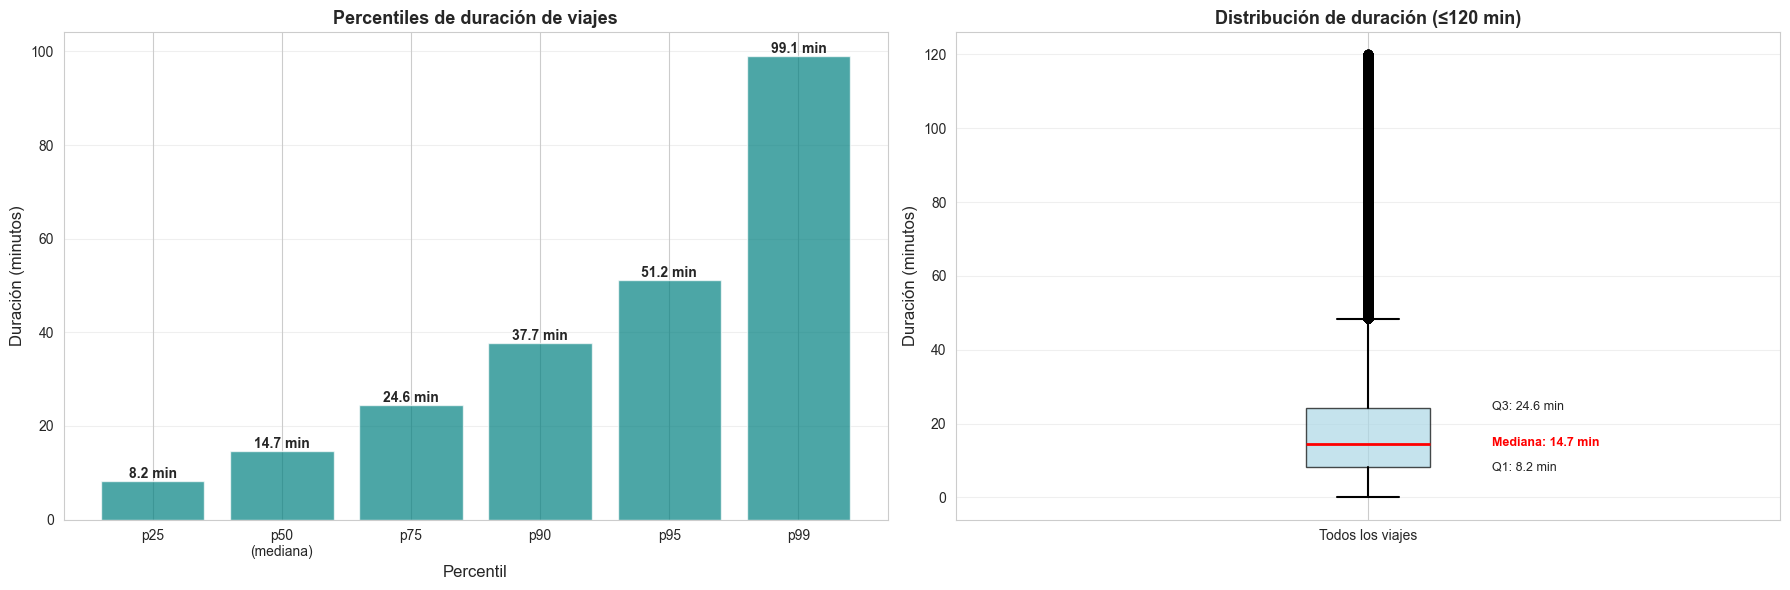


Resumen de duración:
  • 25% de los viajes duran hasta 8.2 minutos
  • 50% de los viajes duran hasta 14.7 minutos (mediana)
  • 75% de los viajes duran hasta 24.6 minutos
  • 90% de los viajes duran hasta 37.7 minutos
  • 95% de los viajes duran hasta 51.2 minutos
  • 99% de los viajes duran hasta 99.1 minutos

Viajes de hasta 120 min representan el 99.32% del total


In [55]:
# Estadísticas descriptivas de duración
# Convertir a minutos para el análisis
df_con_minutos = df.with_columns(
    (pl.col("duracion_recorrido") / 60).alias("duracion_minutos")
)

estadisticas_duracion = df_con_minutos.select(pl.col("duracion_minutos")).describe()

print("Estadísticas de duración de viajes (en minutos):")
print(estadisticas_duracion)

# Percentiles adicionales
percentiles = df_con_minutos.select([
    pl.col("duracion_minutos").quantile(0.25).alias("p25"),
    pl.col("duracion_minutos").quantile(0.50).alias("p50_mediana"),
    pl.col("duracion_minutos").quantile(0.75).alias("p75"),
    pl.col("duracion_minutos").quantile(0.90).alias("p90"),
    pl.col("duracion_minutos").quantile(0.95).alias("p95"),
    pl.col("duracion_minutos").quantile(0.99).alias("p99"),
])

print("\nPercentiles de duración (en minutos):")
print(percentiles)

# Visualización de percentiles y distribución
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

# Gráfico 1: Bar chart de percentiles
percentil_nombres = ['p25', 'p50\n(mediana)', 'p75', 'p90', 'p95', 'p99']
percentil_valores = [
    percentiles['p25'][0],
    percentiles['p50_mediana'][0],
    percentiles['p75'][0],
    percentiles['p90'][0],
    percentiles['p95'][0],
    percentiles['p99'][0]
]

bars = ax1.bar(percentil_nombres, percentil_valores, color='teal', alpha=0.7)
ax1.set_xlabel("Percentil", fontsize=12)
ax1.set_ylabel("Duración (minutos)", fontsize=12)
ax1.set_title("Percentiles de duración de viajes", fontsize=13, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)

# Agregar valores encima de las barras
for idx, (bar, val) in enumerate(zip(bars, percentil_valores)):
    ax1.text(bar.get_x() + bar.get_width()/2, val, f'{val:.1f} min',
             ha='center', va='bottom', fontsize=10, fontweight='bold')

# Gráfico 2: Box plot de duración (filtrado hasta 120 min para mejor visualización)
datos_filtrados = df_con_minutos.filter(pl.col("duracion_minutos") <= 120)["duracion_minutos"].to_list()

bp = ax2.boxplot(datos_filtrados,
                 vert=True,
                 patch_artist=True,
                 medianprops=dict(color='red', linewidth=2),
                 boxprops=dict(facecolor='lightblue', alpha=0.7),
                 whiskerprops=dict(linewidth=1.5),
                 capprops=dict(linewidth=1.5))

ax2.set_ylabel("Duración (minutos)", fontsize=12)
ax2.set_title("Distribución de duración (≤120 min)", fontsize=13, fontweight='bold')
ax2.set_xticks([1])
ax2.set_xticklabels(['Todos los viajes'])
ax2.grid(axis='y', alpha=0.3)

# Agregar anotaciones en el boxplot
q1, median, q3 = percentiles['p25'][0], percentiles['p50_mediana'][0], percentiles['p75'][0]
ax2.text(1.15, q1, f'Q1: {q1:.1f} min', va='center', fontsize=9)
ax2.text(1.15, median, f'Mediana: {median:.1f} min', va='center', fontsize=9, color='red', fontweight='bold')
ax2.text(1.15, q3, f'Q3: {q3:.1f} min', va='center', fontsize=9)

plt.tight_layout()
plt.show()

# Resumen adicional
print(f"\nResumen de duración:")
print(f"  • 25% de los viajes duran hasta {percentil_valores[0]:.1f} minutos")
print(f"  • 50% de los viajes duran hasta {percentil_valores[1]:.1f} minutos (mediana)")
print(f"  • 75% de los viajes duran hasta {percentil_valores[2]:.1f} minutos")
print(f"  • 90% de los viajes duran hasta {percentil_valores[3]:.1f} minutos")
print(f"  • 95% de los viajes duran hasta {percentil_valores[4]:.1f} minutos")
print(f"  • 99% de los viajes duran hasta {percentil_valores[5]:.1f} minutos")
print(f"\nViajes de hasta 120 min representan el {(len(datos_filtrados)/df.height)*100:.2f}% del total")

=== INVESTIGACIÓN DE DURACIÓN ===
Columna original está en SEGUNDOS

Estadísticas básicas (en minutos):
  Mínimo: 0.00 min
  Máximo: 42852.75 min
  Promedio: 21.25 min
  Mediana: 14.68 min


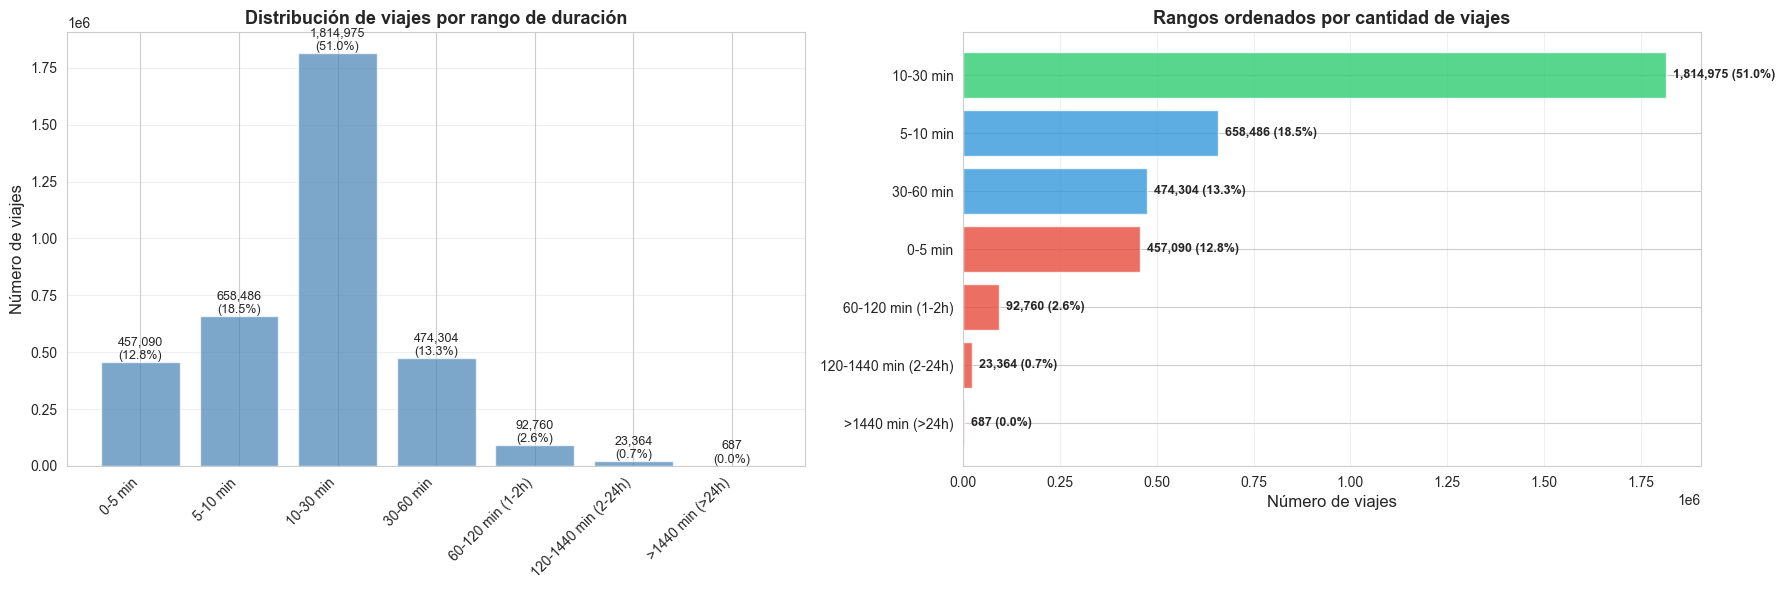

In [56]:
# Investigación de la columna duracion_recorrido
print("=== INVESTIGACIÓN DE DURACIÓN ===")
print(f"Columna original está en SEGUNDOS\n")

# Crear columna en minutos para análisis
df_minutos = df.with_columns(
    (pl.col("duracion_recorrido") / 60).alias("duracion_minutos")
)

# Estadísticas básicas
stats = {
    "Mínimo": df_minutos['duracion_minutos'].min(),
    "Máximo": df_minutos['duracion_minutos'].max(),
    "Promedio": df_minutos['duracion_minutos'].mean(),
    "Mediana": df_minutos['duracion_minutos'].median()
}

print("Estadísticas básicas (en minutos):")
for key, value in stats.items():
    print(f"  {key}: {value:.2f} min")

# Distribución por rangos
rangos = [
    ("0-5 min", 0, 5),
    ("5-10 min", 5, 10),
    ("10-30 min", 10, 30),
    ("30-60 min", 30, 60),
    ("60-120 min (1-2h)", 60, 120),
    ("120-1440 min (2-24h)", 120, 1440),
    (">1440 min (>24h)", 1440, float('inf'))
]

nombres_rangos = []
conteos = []
porcentajes = []

for nombre, min_val, max_val in rangos:
    if max_val == float('inf'):
        count = df_minutos.filter(pl.col("duracion_minutos") > min_val).height
    else:
        count = df_minutos.filter(
            (pl.col("duracion_minutos") > min_val) & 
            (pl.col("duracion_minutos") <= max_val)
        ).height
    porcentaje = (count / df.height) * 100
    nombres_rangos.append(nombre)
    conteos.append(count)
    porcentajes.append(porcentaje)

# Visualización con gráfico de barras
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

# Gráfico 1: Barras con cantidad
ax1.bar(range(len(nombres_rangos)), conteos, color='steelblue', alpha=0.7)
ax1.set_xticks(range(len(nombres_rangos)))
ax1.set_xticklabels(nombres_rangos, rotation=45, ha='right', fontsize=10)
ax1.set_ylabel("Número de viajes", fontsize=12)
ax1.set_title("Distribución de viajes por rango de duración", fontsize=13, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)
# Agregar valores encima de las barras
for idx, (count, pct) in enumerate(zip(conteos, porcentajes)):
    ax1.text(idx, count, f'{count:,}\n({pct:.1f}%)', ha='center', va='bottom', fontsize=9)

# Gráfico 2: Barras horizontales ordenadas por cantidad
# Ordenar por cantidad
rangos_ordenados = sorted(zip(nombres_rangos, conteos, porcentajes), key=lambda x: x[1], reverse=True)
rangos_nombres_ord = [r[0] for r in rangos_ordenados]
rangos_conteos_ord = [r[1] for r in rangos_ordenados]
rangos_pct_ord = [r[2] for r in rangos_ordenados]

# Código de colores: verde para rango gratis, azul para frecuentes, rojo para extremos
colores = ['#2ecc71' if '10-30' in n else '#3498db' if any(x in n for x in ['5-10', '30-60']) else '#e74c3c' for n in rangos_nombres_ord]

barras = ax2.barh(range(len(rangos_nombres_ord)), rangos_conteos_ord, color=colores, alpha=0.8)
ax2.set_yticks(range(len(rangos_nombres_ord)))
ax2.set_yticklabels(rangos_nombres_ord, fontsize=10)
ax2.set_xlabel("Número de viajes", fontsize=12)
ax2.set_title("Rangos ordenados por cantidad de viajes", fontsize=13, fontweight='bold')
ax2.invert_yaxis()
ax2.grid(axis='x', alpha=0.3)

# Agregar valores a las barras
for idx, (count, pct) in enumerate(zip(rangos_conteos_ord, rangos_pct_ord)):
    ax2.text(count, idx, f'  {count:,} ({pct:.1f}%)', va='center', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()

=== ANÁLISIS DE VIAJES MUY CORTOS ===

Duración = 0 min:          37,618 ( 1.06%) ← Probables errores
Duración 0-1 min:         287,416 ( 8.08%) ← Viajes muy cortos/sospechosos
Duración 1-5 min:         169,674 ( 4.77%)
Duración 5-60 min:       2,947,765 (82.82%)
──────────────────────────────────────────────────────────────────────
Total (0-60 min):        3,442,473



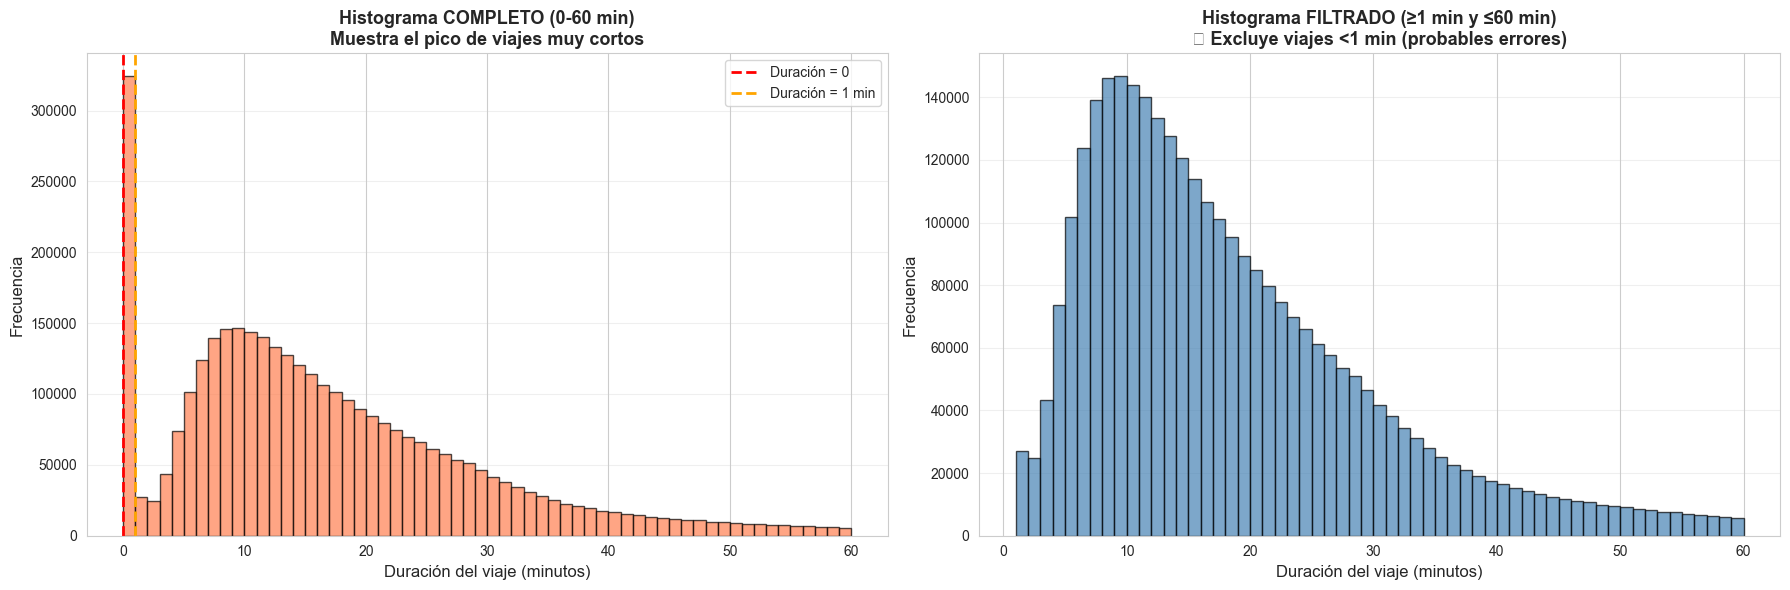


RECOMENDACIÓN:
   • Viajes <1 min (325,034 = 9.13%) son probables errores/cancelaciones
   • Para análisis de patrones reales, considerar solo viajes ≥1 minuto
   • Esto representa 3,118,085 viajes válidos (87.6% del total)


In [57]:
# Distribución de duraciones (histograma) - Análisis detallado
# Convertir a minutos y analizar viajes muy cortos
df_duracion_min = df.with_columns(
    (pl.col("duracion_recorrido") / 60).alias("duracion_minutos")
)

# Análisis de viajes muy cortos (posibles errores)
print("=== ANÁLISIS DE VIAJES MUY CORTOS ===\n")

viajes_0 = df_duracion_min.filter(pl.col("duracion_minutos") == 0)
viajes_0_a_1 = df_duracion_min.filter((pl.col("duracion_minutos") > 0) & (pl.col("duracion_minutos") <= 1))
viajes_1_a_5 = df_duracion_min.filter((pl.col("duracion_minutos") > 1) & (pl.col("duracion_minutos") <= 5))
viajes_5_a_60 = df_duracion_min.filter((pl.col("duracion_minutos") > 5) & (pl.col("duracion_minutos") <= 60))

print(f"Duración = 0 min:        {viajes_0.height:>8,} ({viajes_0.height/df.height*100:5.2f}%) ← Probables errores")
print(f"Duración 0-1 min:        {viajes_0_a_1.height:>8,} ({viajes_0_a_1.height/df.height*100:5.2f}%) ← Viajes muy cortos/sospechosos")
print(f"Duración 1-5 min:        {viajes_1_a_5.height:>8,} ({viajes_1_a_5.height/df.height*100:5.2f}%)")
print(f"Duración 5-60 min:       {viajes_5_a_60.height:>8,} ({viajes_5_a_60.height/df.height*100:5.2f}%)")
print(f"{'─'*70}")
print(f"Total (0-60 min):        {viajes_0.height + viajes_0_a_1.height + viajes_1_a_5.height + viajes_5_a_60.height:>8,}\n")

# Crear visualización con dos histogramas: uno completo y otro filtrado
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

# Histograma 1: Todos los viajes 0-60 min (muestra el problema)
todos_0_60 = df_duracion_min.filter(pl.col("duracion_minutos") <= 60)["duracion_minutos"].to_list()
ax1.hist(todos_0_60, bins=60, color='coral', edgecolor='black', alpha=0.7)
ax1.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Duración = 0')
ax1.axvline(x=1, color='orange', linestyle='--', linewidth=2, label='Duración = 1 min')
ax1.set_xlabel("Duración del viaje (minutos)", fontsize=12)
ax1.set_ylabel("Frecuencia", fontsize=12)
ax1.set_title("Histograma COMPLETO (0-60 min)\nMuestra el pico de viajes muy cortos", fontsize=13, fontweight='bold')
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# Histograma 2: Solo viajes >= 1 minuto (más limpio)
viajes_validos = df_duracion_min.filter(
    (pl.col("duracion_minutos") >= 1) &  # Al menos 1 minuto
    (pl.col("duracion_minutos") <= 60)
)["duracion_minutos"].to_list()

ax2.hist(viajes_validos, bins=59, range=(1, 60), color='steelblue', edgecolor='black', alpha=0.7)
ax2.set_xlabel("Duración del viaje (minutos)", fontsize=12)
ax2.set_ylabel("Frecuencia", fontsize=12)
ax2.set_title("Histograma FILTRADO (≥1 min y ≤60 min)\n✓ Excluye viajes <1 min (probables errores)", fontsize=13, fontweight='bold')
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("\nRECOMENDACIÓN:")
print(f"   • Viajes <1 min ({viajes_0.height + viajes_0_a_1.height:,} = {(viajes_0.height + viajes_0_a_1.height)/df.height*100:.2f}%) son probables errores/cancelaciones")
print(f"   • Para análisis de patrones reales, considerar solo viajes ≥1 minuto")
print(f"   • Esto representa {len(viajes_validos):,} viajes válidos ({len(viajes_validos)/df.height*100:.1f}% del total)")

### Filtrado de datos: Creación del dataset limpio

**Decisión de limpieza de datos:**  

Con base en el análisis anterior, identificamos dos grupos de viajes anómalos que deben excluirse:

1. **Viajes <1 minuto (~9%):** Probables errores de registro o cancelaciones inmediatas
2. **Viajes >120 minutos (~0.7%):** Probables casos de robo, pérdida o olvido de la bicicleta

**Justificación:**
- Los viajes entre 1-120 minutos representan el **~99.3% del total**
- Estos representan el uso real y esperado del sistema
- Excluir los extremos mejora significativamente la calidad de todos los análisis posteriores

Para todos los análisis posteriores (temporal, geoespacial, usuarios), utilizaremos únicamente el **dataset limpio** con viajes entre 1 y 120 minutos.

In [58]:
# Crear DataFrame limpio: filtrar viajes anómalos
# Excluir:
#   - Viajes <1 minuto (60 segundos): probables errores/cancelaciones
#   - Viajes >120 minutos (7200 segundos): probables robos/pérdidas/olvidos

df_limpio = df.filter(
    (pl.col("duracion_recorrido") >= 60) &      # >= 1 minuto
    (pl.col("duracion_recorrido") <= 7200)      # <= 120 minutos (2 horas)
)

# Estadísticas de filtrado
viajes_muy_cortos = df.filter(pl.col("duracion_recorrido") < 60).height
viajes_muy_largos = df.filter(pl.col("duracion_recorrido") > 7200).height
viajes_excluidos = viajes_muy_cortos + viajes_muy_largos

print("=== LIMPIEZA DE DATOS ===\n")
print(f"Dataset original:              {df.height:>10,} registros (100.00%)")
print(f"\nViajes excluidos:")
print(f"  • <1 minuto (errores):       {viajes_muy_cortos:>10,} registros ({viajes_muy_cortos/df.height*100:5.2f}%)")
print(f"  • >120 minutos (anómalos):   {viajes_muy_largos:>10,} registros ({viajes_muy_largos/df.height*100:5.2f}%)")
print(f"  • Total excluidos:           {viajes_excluidos:>10,} registros ({viajes_excluidos/df.height*100:5.2f}%)")
print(f"\nDataset limpio (1-120 min):    {df_limpio.height:>10,} registros ({df_limpio.height/df.height*100:5.2f}%)")
print(f"\n✓ Todos los análisis posteriores usarán el dataset limpio")
print(f"  (solo viajes entre 1 y 120 minutos)")

=== LIMPIEZA DE DATOS ===

Dataset original:               3,559,284 registros (100.00%)

Viajes excluidos:
  • <1 minuto (errores):          324,388 registros ( 9.11%)
  • >120 minutos (anómalos):       24,051 registros ( 0.68%)
  • Total excluidos:              348,439 registros ( 9.79%)

Dataset limpio (1-120 min):     3,210,845 registros (90.21%)

✓ Todos los análisis posteriores usarán el dataset limpio
  (solo viajes entre 1 y 120 minutos)


shape: (5, 3)
┌─────────────────────┬──────────────┬────────────┐
│ categoria_duracion  ┆ total_viajes ┆ porcentaje │
│ ---                 ┆ ---          ┆ ---        │
│ str                 ┆ u32          ┆ f64        │
╞═════════════════════╪══════════════╪════════════╡
│ Corto (6-15 min)    ┆ 1323691      ┆ 37.189811  │
│ Medio (16-30 min)   ┆ 1149770      ┆ 32.303407  │
│ Muy corto (≤5 min)  ┆ 494708       ┆ 13.899088  │
│ Largo (31-60 min)   ┆ 474304       ┆ 13.325826  │
│ Muy largo (>60 min) ┆ 116811       ┆ 3.281868   │
└─────────────────────┴──────────────┴────────────┘


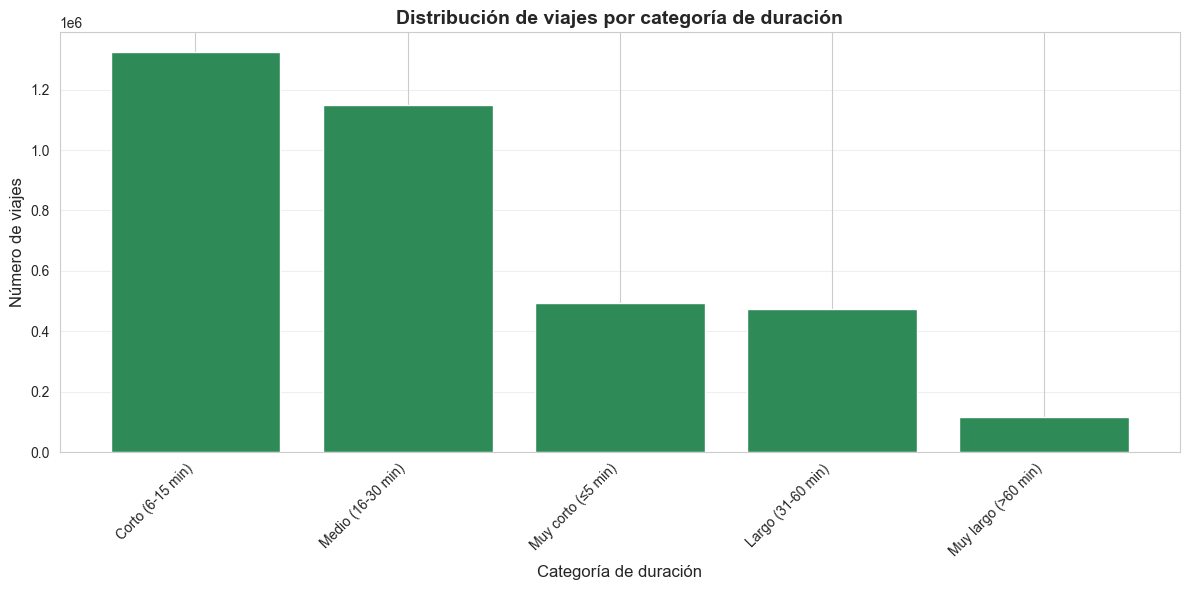

In [59]:
# Categorización de viajes por duración
df_categorizado = df.with_columns(
    (pl.col("duracion_recorrido") / 60).alias("duracion_minutos")
).with_columns(
    pl.when(pl.col("duracion_minutos") <= 5).then(pl.lit("Muy corto (≤5 min)"))
    .when(pl.col("duracion_minutos") <= 15).then(pl.lit("Corto (6-15 min)"))
    .when(pl.col("duracion_minutos") <= 30).then(pl.lit("Medio (16-30 min)"))
    .when(pl.col("duracion_minutos") <= 60).then(pl.lit("Largo (31-60 min)"))
    .otherwise(pl.lit("Muy largo (>60 min)"))
    .alias("categoria_duracion")
)

dist_categorias = (
    df_categorizado
    .group_by("categoria_duracion")
    .agg([
        pl.len().alias("total_viajes"),
        (pl.len() / df.height * 100).alias("porcentaje")
    ])
    .sort("total_viajes", descending=True)
)

print(dist_categorias)

# Visualización
plt.figure(figsize=(12, 6))
plt.bar(dist_categorias["categoria_duracion"].to_list(), dist_categorias["total_viajes"].to_list(), color='seagreen')
plt.xlabel("Categoría de duración", fontsize=12)
plt.ylabel("Número de viajes", fontsize=12)
plt.title("Distribución de viajes por categoría de duración", fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

shape: (2, 4)
┌──────────────────┬───────────────────┬──────────────────┬──────────────┐
│ modelo_bicicleta ┆ duracion_promedio ┆ duracion_mediana ┆ total_viajes │
│ ---              ┆ ---               ┆ ---              ┆ ---          │
│ str              ┆ f64               ┆ f64              ┆ u32          │
╞══════════════════╪═══════════════════╪══════════════════╪══════════════╡
│ FIT              ┆ 21.404635         ┆ 14.583333        ┆ 2582443      │
│ ICONIC           ┆ 20.830676         ┆ 14.933333        ┆ 976841       │
└──────────────────┴───────────────────┴──────────────────┴──────────────┘


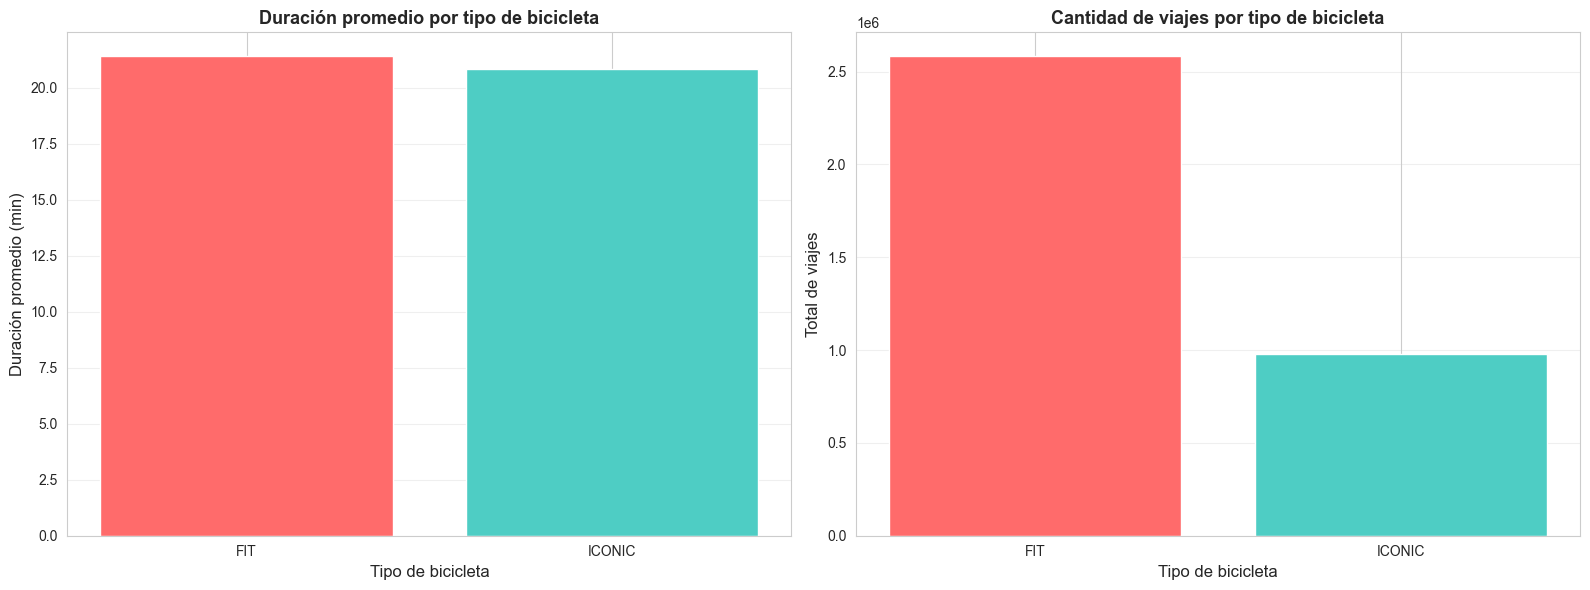

In [60]:
# Duración promedio por tipo de bicicleta
duracion_tipo_bici = (
    df
    .with_columns(
        (pl.col("duracion_recorrido") / 60).alias("duracion_minutos")
    )
    .group_by("modelo_bicicleta")
    .agg([
        pl.col("duracion_minutos").mean().alias("duracion_promedio"),
        pl.col("duracion_minutos").median().alias("duracion_mediana"),
        pl.len().alias("total_viajes")
    ])
    .sort("duracion_promedio", descending=True)
)

print(duracion_tipo_bici)

# Visualización comparativa
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

ax1.bar(duracion_tipo_bici["modelo_bicicleta"].to_list(), 
        duracion_tipo_bici["duracion_promedio"].to_list(), 
        color=['#FF6B6B', '#4ECDC4'])
ax1.set_xlabel("Tipo de bicicleta", fontsize=12)
ax1.set_ylabel("Duración promedio (min)", fontsize=12)
ax1.set_title("Duración promedio por tipo de bicicleta", fontsize=13, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)

ax2.bar(duracion_tipo_bici["modelo_bicicleta"].to_list(), 
        duracion_tipo_bici["total_viajes"].to_list(), 
        color=['#FF6B6B', '#4ECDC4'])
ax2.set_xlabel("Tipo de bicicleta", fontsize=12)
ax2.set_ylabel("Total de viajes", fontsize=12)
ax2.set_title("Cantidad de viajes por tipo de bicicleta", fontsize=13, fontweight='bold')
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

Análisis IQR sobre dataset limpio (1-120 min):

Q1 (25%): 9.83 min
Q3 (75%): 25.57 min
IQR: 15.73 min
Límite inferior: 1.00 min (ajustado al mínimo permitido)
Límite superior: 49.17 min

Dentro del rango 1-120 min:
  • Outliers IQR:    172,963 ( 5.39%)
  • Viajes normales:  3,037,882 (94.61%)


/var/folders/rr/b8q7zgq911j0wd35x_j_38940000gn/T/ipykernel_1344/3313843655.py:63: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp2 = ax2.boxplot([todos_datos, datos_sin_outliers_iqr],


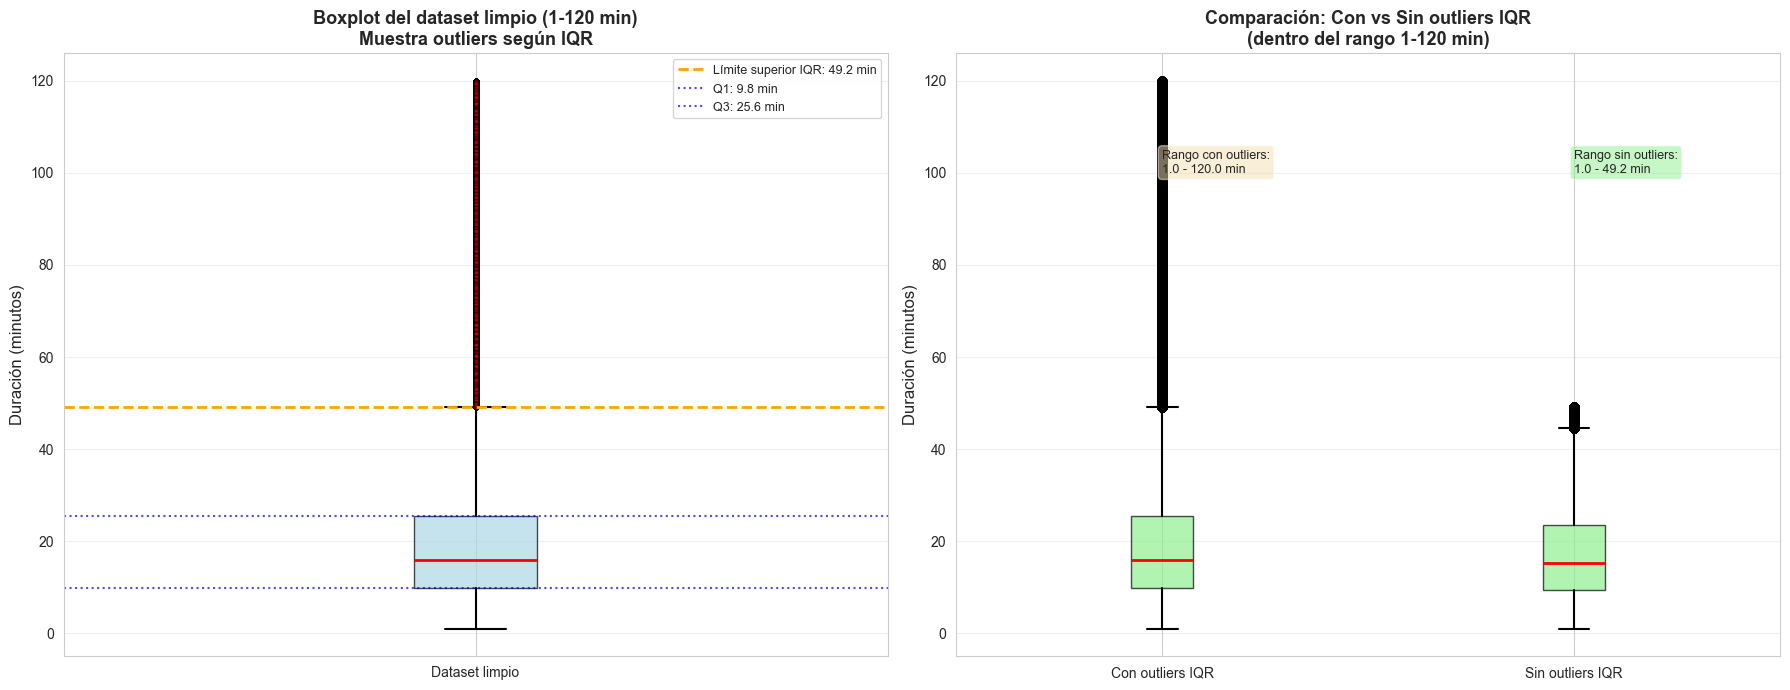


Interpretación:
  • Dentro del rango 1-120 min, el método IQR detecta 172,963 outliers
  • Estos representan viajes muy cortos (1--14 min) o muy largos (49-120 min)
  • La mayoría de viajes (94.6%) están en el rango IQR [1-49] min
  • Esto confirma que la mayor concentración está en viajes de duración moderada


In [61]:
# Detección de outliers en duración (DENTRO del rango 1-120 min)
# Usando el método IQR (Interquartile Range) sobre el dataset limpio

df_limpio_minutos = df_limpio.with_columns(
    (pl.col("duracion_recorrido") / 60).alias("duracion_minutos")
)

q1 = df_limpio_minutos["duracion_minutos"].quantile(0.25)
q3 = df_limpio_minutos["duracion_minutos"].quantile(0.75)
iqr = q3 - q1
limite_inferior = q1 - 1.5 * iqr
limite_superior = q3 + 1.5 * iqr

# Filtrar outliers dentro del rango normal (1-120 min)
outliers_normales = df_limpio_minutos.filter(
    (pl.col("duracion_minutos") < limite_inferior) | 
    (pl.col("duracion_minutos") > limite_superior)
)

datos_normales = df_limpio_minutos.filter(
    (pl.col("duracion_minutos") >= limite_inferior) & 
    (pl.col("duracion_minutos") <= limite_superior)
)

print(f"Análisis IQR sobre dataset limpio (1-120 min):\n")
print(f"Q1 (25%): {q1:.2f} min")
print(f"Q3 (75%): {q3:.2f} min")
print(f"IQR: {iqr:.2f} min")
print(f"Límite inferior: {max(1, limite_inferior):.2f} min (ajustado al mínimo permitido)")
print(f"Límite superior: {limite_superior:.2f} min")
print(f"\nDentro del rango 1-120 min:")
print(f"  • Outliers IQR: {outliers_normales.height:>10,} ({outliers_normales.height/df_limpio.height*100:5.2f}%)")
print(f"  • Viajes normales: {datos_normales.height:>10,} ({datos_normales.height/df_limpio.height*100:5.2f}%)")

# Visualización con boxplot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))

# Boxplot 1: Dataset limpio completo (1-120 min)
todos_datos = df_limpio_minutos["duracion_minutos"].to_list()
bp1 = ax1.boxplot(todos_datos,
                   vert=True,
                   patch_artist=True,
                   medianprops=dict(color='red', linewidth=2),
                   boxprops=dict(facecolor='lightblue', alpha=0.7),
                   whiskerprops=dict(linewidth=1.5),
                   capprops=dict(linewidth=1.5),
                   flierprops=dict(marker='o', markerfacecolor='red', markersize=3, alpha=0.4))

ax1.axhline(y=limite_superior, color='orange', linestyle='--', linewidth=2, label=f'Límite superior IQR: {limite_superior:.1f} min')
ax1.axhline(y=q1, color='blue', linestyle=':', linewidth=1.5, alpha=0.7, label=f'Q1: {q1:.1f} min')
ax1.axhline(y=q3, color='blue', linestyle=':', linewidth=1.5, alpha=0.7, label=f'Q3: {q3:.1f} min')

ax1.set_ylabel("Duración (minutos)", fontsize=12)
ax1.set_title("Boxplot del dataset limpio (1-120 min)\nMuestra outliers según IQR", fontsize=13, fontweight='bold')
ax1.set_xticks([1])
ax1.set_xticklabels(['Dataset limpio'])
ax1.legend(loc='upper right', fontsize=9)
ax1.grid(axis='y', alpha=0.3)

# Boxplot 2: Comparación - Con outliers IQR vs Sin outliers IQR
datos_sin_outliers_iqr = datos_normales["duracion_minutos"].to_list()

bp2 = ax2.boxplot([todos_datos, datos_sin_outliers_iqr],
                   labels=['Con outliers IQR', 'Sin outliers IQR'],
                   patch_artist=True,
                   medianprops=dict(color='red', linewidth=2),
                   boxprops=dict(facecolor='lightgreen', alpha=0.7),
                   whiskerprops=dict(linewidth=1.5),
                   capprops=dict(linewidth=1.5))

ax2.set_ylabel("Duración (minutos)", fontsize=12)
ax2.set_title("Comparación: Con vs Sin outliers IQR\n(dentro del rango 1-120 min)", fontsize=13, fontweight='bold')
ax2.grid(axis='y', alpha=0.3)

# Agregar estadísticas
mediana_con = q1 + (q3 - q1) / 2
mediana_sin = datos_normales["duracion_minutos"].median()
ax2.text(1, 100, f'Rango con outliers:\n{df_limpio_minutos["duracion_minutos"].min():.1f} - {df_limpio_minutos["duracion_minutos"].max():.1f} min', 
         fontsize=9, bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
ax2.text(2, 100, f'Rango sin outliers:\n{datos_normales["duracion_minutos"].min():.1f} - {datos_normales["duracion_minutos"].max():.1f} min', 
         fontsize=9, bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.5))

plt.tight_layout()
plt.show()

print(f"\nInterpretación:")
print(f"  • Dentro del rango 1-120 min, el método IQR detecta {outliers_normales.height:,} outliers")
print(f"  • Estos representan viajes muy cortos (1-{limite_inferior:.0f} min) o muy largos ({limite_superior:.0f}-120 min)")
print(f"  • La mayoría de viajes ({datos_normales.height/df_limpio.height*100:.1f}%) están en el rango IQR [{max(1, limite_inferior):.0f}-{limite_superior:.0f}] min")
print(f"  • Esto confirma que la mayor concentración está en viajes de duración moderada")

/var/folders/rr/b8q7zgq911j0wd35x_j_38940000gn/T/ipykernel_1344/3921272599.py:13: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(datos_por_tipo,


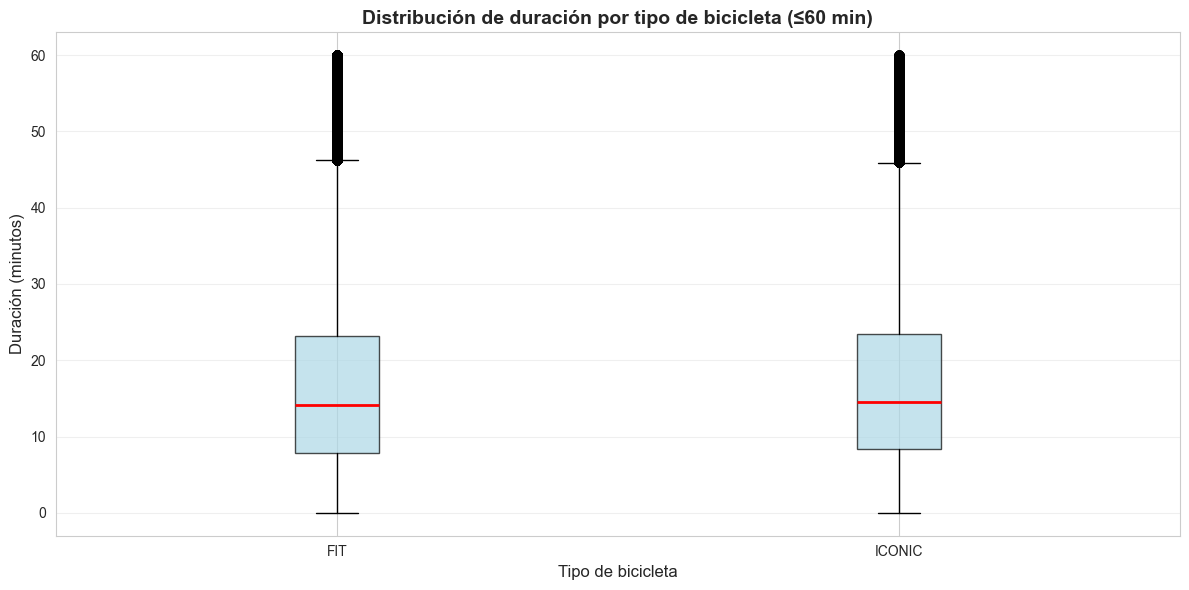

In [62]:
# Boxplot de duración por tipo de bicicleta
# Filtrar para mejor visualización y convertir a minutos
datos_boxplot = df.with_columns(
    (pl.col("duracion_recorrido") / 60).alias("duracion_minutos")
).filter(pl.col("duracion_minutos") <= 60)

fig, ax = plt.subplots(figsize=(12, 6))
datos_por_tipo = [
    datos_boxplot.filter(pl.col("modelo_bicicleta") == tipo)["duracion_minutos"].to_list()
    for tipo in datos_boxplot["modelo_bicicleta"].unique().sort().to_list()
]

bp = ax.boxplot(datos_por_tipo, 
                labels=datos_boxplot["modelo_bicicleta"].unique().sort().to_list(),
                patch_artist=True,
                medianprops=dict(color='red', linewidth=2),
                boxprops=dict(facecolor='lightblue', alpha=0.7))

ax.set_xlabel("Tipo de bicicleta", fontsize=12)
ax.set_ylabel("Duración (minutos)", fontsize=12)
ax.set_title("Distribución de duración por tipo de bicicleta (≤60 min)", fontsize=14, fontweight='bold')
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

## C. Análisis Temporal

In [63]:
# Preparación: extraer variables temporales
# Las fechas ya fueron convertidas a Datetime en la celda de conversión de tipos

df_temporal = df_limpio.with_columns([
    pl.col("fecha_origen_recorrido").dt.hour().alias("hora"),
    pl.col("fecha_origen_recorrido").dt.weekday().alias("dia_semana"),
    pl.col("fecha_origen_recorrido").dt.month().alias("mes"),
    pl.col("fecha_origen_recorrido").dt.date().alias("fecha"),
])

print("Variables temporales extraídas:")
df_temporal.select(["fecha_origen_recorrido", "hora", "dia_semana", "mes", "fecha"]).head(5)

Variables temporales extraídas:


fecha_origen_recorrido,hora,dia_semana,mes,fecha
datetime[μs],i8,i8,i8,date
2024-01-23 18:36:00,18,2,1,2024-01-23
2024-01-23 22:41:20,22,2,1,2024-01-23
2024-01-23 15:18:39,15,2,1,2024-01-23
2024-01-23 17:48:05,17,2,1,2024-01-23
2024-01-23 21:17:38,21,2,1,2024-01-23


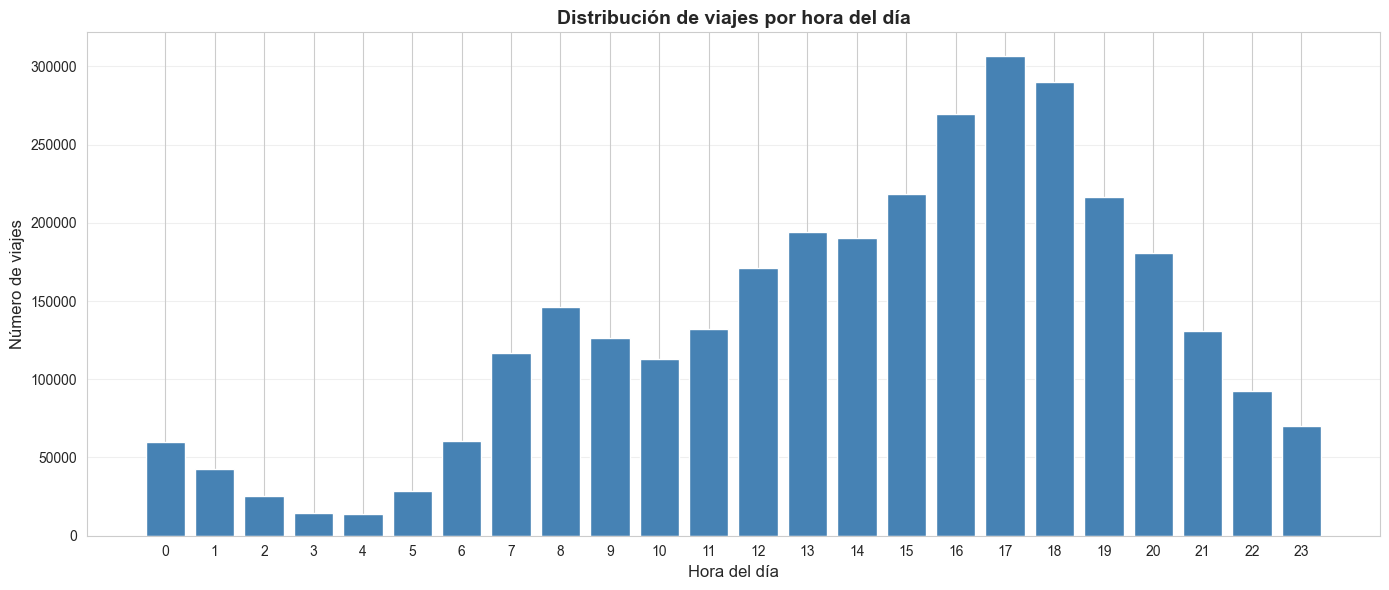

shape: (24, 2)
┌──────┬──────────────┐
│ hora ┆ total_viajes │
│ ---  ┆ ---          │
│ i8   ┆ u32          │
╞══════╪══════════════╡
│ 0    ┆ 59760        │
│ 1    ┆ 42433        │
│ 2    ┆ 25300        │
│ 3    ┆ 14645        │
│ 4    ┆ 14098        │
│ 5    ┆ 28561        │
│ 6    ┆ 60228        │
│ 7    ┆ 117086       │
│ 8    ┆ 146456       │
│ 9    ┆ 126332       │
│ …    ┆ …            │
│ 14   ┆ 190167       │
│ 15   ┆ 218250       │
│ 16   ┆ 269396       │
│ 17   ┆ 306418       │
│ 18   ┆ 290161       │
│ 19   ┆ 216411       │
│ 20   ┆ 180819       │
│ 21   ┆ 130926       │
│ 22   ┆ 92718        │
│ 23   ┆ 70025        │
└──────┴──────────────┘


In [64]:
# Distribución de viajes por hora del día
viajes_por_hora = (
    df_temporal
    .group_by("hora")
    .agg(pl.len().alias("total_viajes"))
    .sort("hora")
)

plt.figure(figsize=(14, 6))
plt.bar(viajes_por_hora["hora"], viajes_por_hora["total_viajes"], color='steelblue')
plt.xlabel("Hora del día", fontsize=12)
plt.ylabel("Número de viajes", fontsize=12)
plt.title("Distribución de viajes por hora del día", fontsize=14, fontweight='bold')
plt.xticks(range(0, 24))
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print(viajes_por_hora)

Valores únicos de dia_semana: [1, 2, 3, 4, 5, 6, 7]
shape: (7, 2)
┌────────────┬──────────────┐
│ dia_semana ┆ total_viajes │
│ ---        ┆ ---          │
│ i8         ┆ u32          │
╞════════════╪══════════════╡
│ 1          ┆ 531675       │
│ 2          ┆ 570912       │
│ 3          ┆ 563656       │
│ 4          ┆ 580122       │
│ 5          ┆ 548132       │
│ 6          ┆ 211222       │
│ 7          ┆ 205126       │
└────────────┴──────────────┘


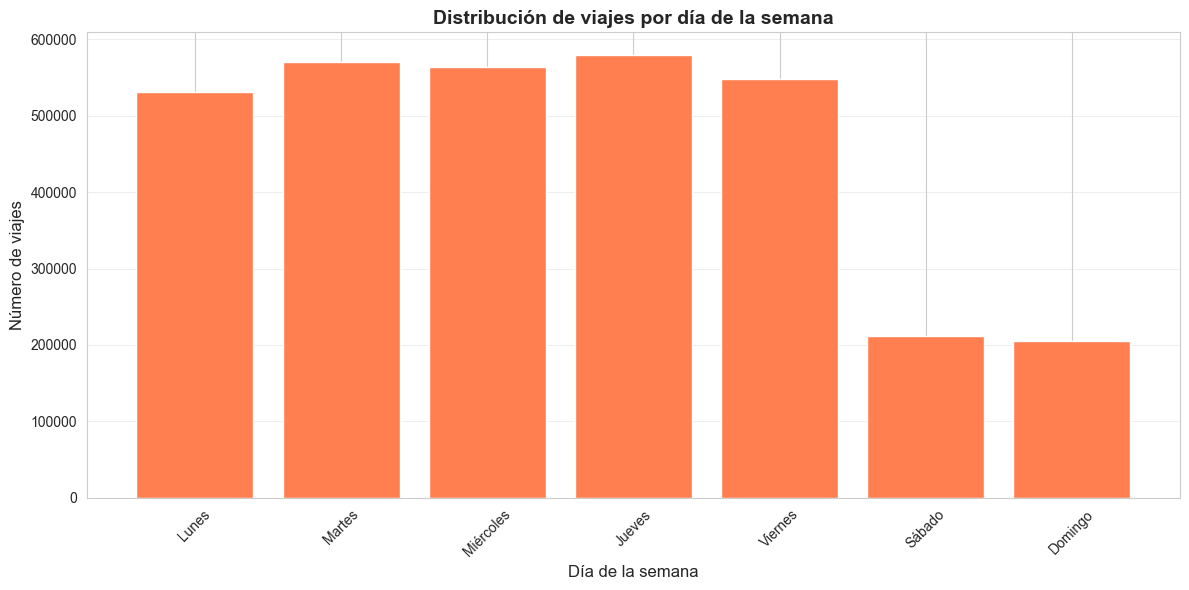

In [65]:
# Distribución de viajes por día de la semana
dias_semana_dict = {1: "Lunes", 2: "Martes", 3: "Miércoles", 4: "Jueves", 5: "Viernes", 6: "Sábado", 7: "Domingo"}

viajes_por_dia = (
    df_temporal
    .group_by("dia_semana")
    .agg(pl.len().alias("total_viajes"))
    .sort("dia_semana")
)

print("Valores únicos de dia_semana:", viajes_por_dia["dia_semana"].to_list())
print(viajes_por_dia)

# Crear nombres de días para visualización
nombres_dias = [dias_semana_dict.get(i, f"Día {i}") for i in viajes_por_dia["dia_semana"].to_list()]

plt.figure(figsize=(12, 6))
plt.bar(nombres_dias, viajes_por_dia["total_viajes"].to_list(), color='coral')
plt.xlabel("Día de la semana", fontsize=12)
plt.ylabel("Número de viajes", fontsize=12)
plt.title("Distribución de viajes por día de la semana", fontsize=14, fontweight='bold')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

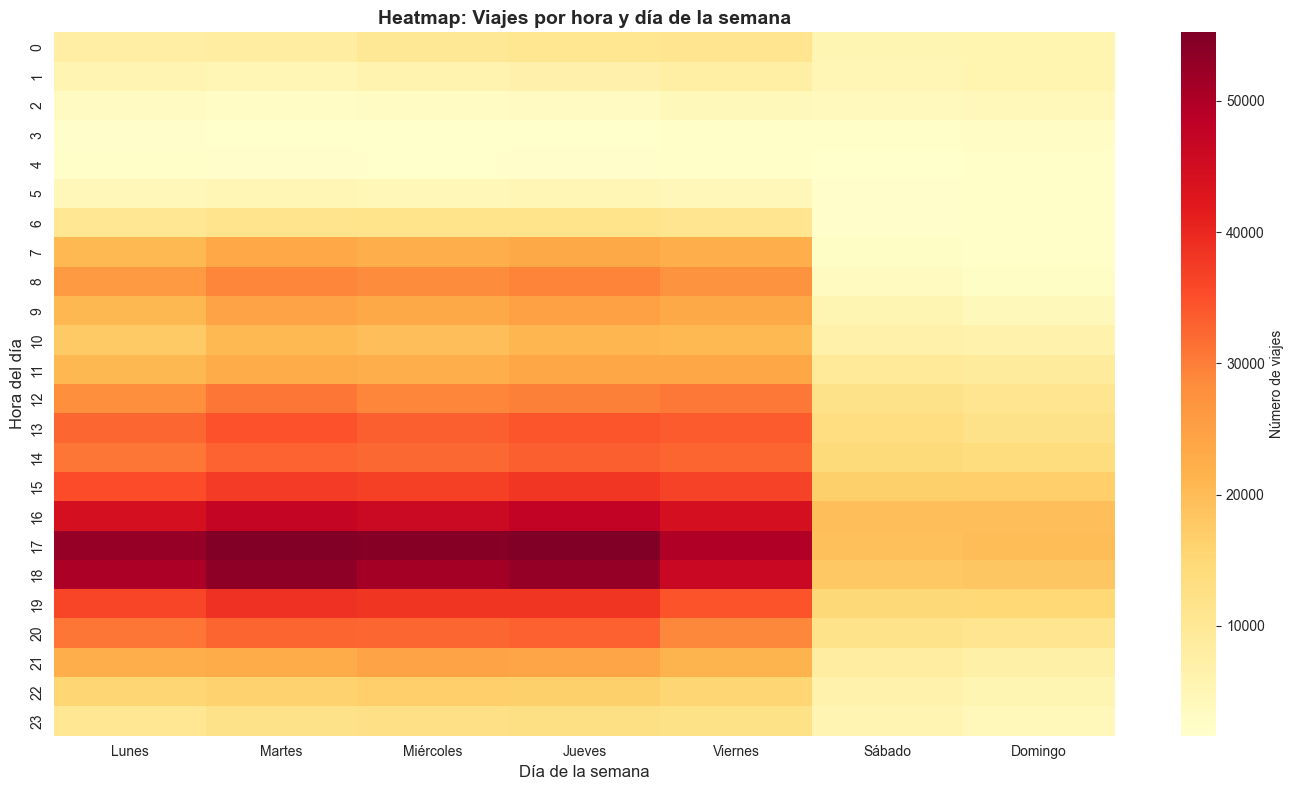

In [66]:
# Heatmap: Viajes por hora y día de la semana
dias_semana_nombres = ["Lunes", "Martes", "Miércoles", "Jueves", "Viernes", "Sábado", "Domingo"]

heatmap_data = (
    df_temporal
    .group_by(["hora", "dia_semana"])
    .agg(pl.len().alias("total_viajes"))
    .sort(["dia_semana", "hora"])
    .pivot(index="hora", on="dia_semana", values="total_viajes")
)

# Matriz para heatmap (columnas 1-7 corresponden a Lun-Dom)
heatmap_matrix = heatmap_data.select(pl.exclude("hora")).to_numpy()

plt.figure(figsize=(14, 8))
sns.heatmap(heatmap_matrix, 
            xticklabels=dias_semana_nombres,
            yticklabels=range(24),
            cmap="YlOrRd", 
            annot=False, 
            fmt="d",
            cbar_kws={'label': 'Número de viajes'})
plt.xlabel("Día de la semana", fontsize=12)
plt.ylabel("Hora del día", fontsize=12)
plt.title("Heatmap: Viajes por hora y día de la semana", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

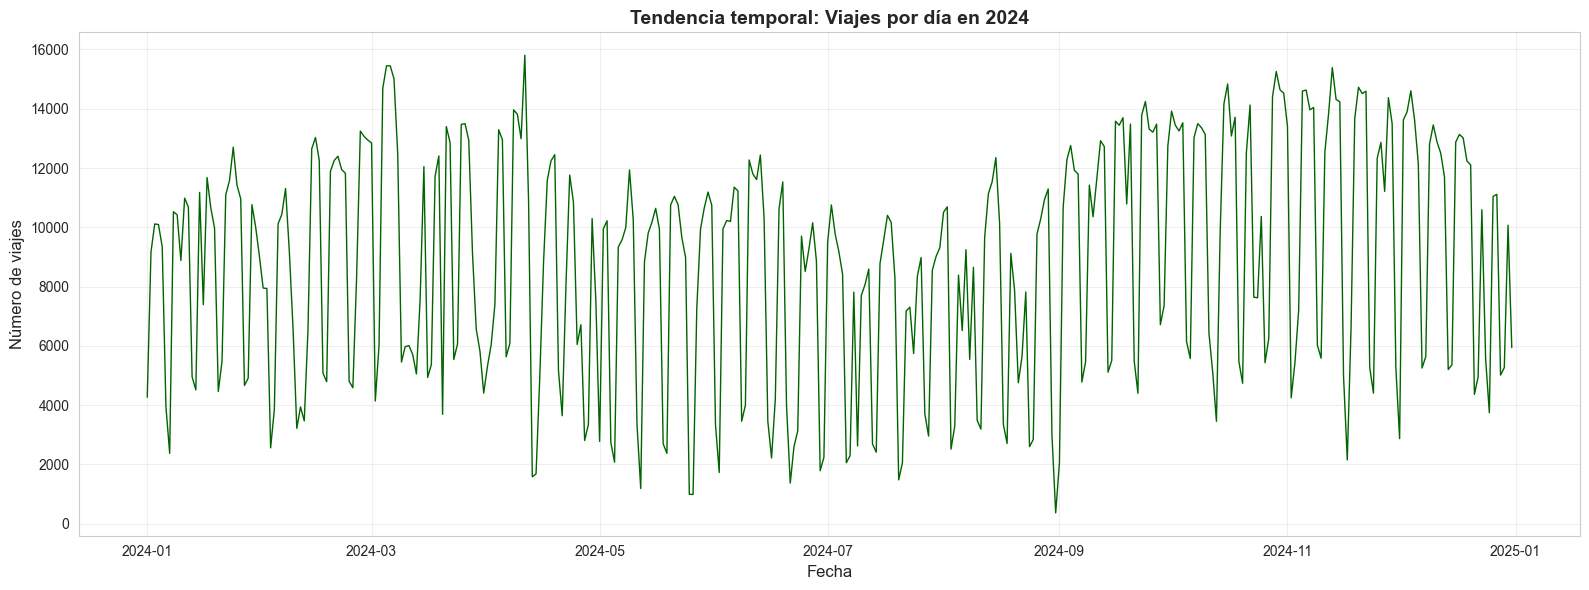

Promedio de viajes por día: 8,773


In [67]:
# Tendencia temporal: viajes por día en 2024
tendencia_diaria = (
    df_temporal
    .group_by("fecha")
    .agg(pl.len().alias("total_viajes"))
    .sort("fecha")
)

plt.figure(figsize=(16, 6))
plt.plot(tendencia_diaria["fecha"], tendencia_diaria["total_viajes"], linewidth=1, color='darkgreen')
plt.xlabel("Fecha", fontsize=12)
plt.ylabel("Número de viajes", fontsize=12)
plt.title("Tendencia temporal: Viajes por día en 2024", fontsize=14, fontweight='bold')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Promedio de viajes por día: {tendencia_diaria['total_viajes'].mean():,.0f}")

Top 10 días con mayor cantidad de viajes:
shape: (10, 2)
┌────────────┬──────────────┐
│ fecha      ┆ total_viajes │
│ ---        ┆ ---          │
│ date       ┆ u32          │
╞════════════╪══════════════╡
│ 2024-04-11 ┆ 15806        │
│ 2024-03-05 ┆ 15448        │
│ 2024-03-06 ┆ 15446        │
│ 2024-11-13 ┆ 15388        │
│ 2024-10-29 ┆ 15257        │
│ 2024-03-07 ┆ 15007        │
│ 2024-10-16 ┆ 14836        │
│ 2024-11-20 ┆ 14726        │
│ 2024-03-04 ┆ 14688        │
│ 2024-10-30 ┆ 14641        │
└────────────┴──────────────┘


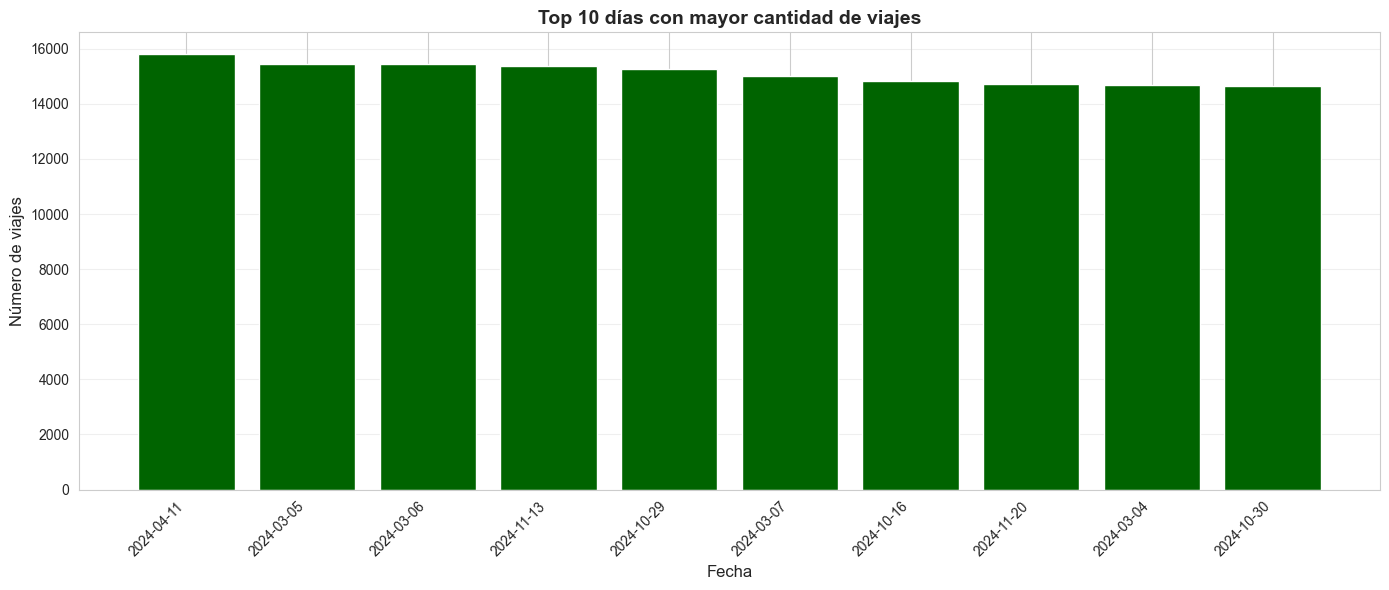


Promedio de viajes en estos días pico: 15,124
Día con más viajes: 2024-04-11 con 15,806 viajes


In [68]:
# Top 10 días con mayor cantidad de viajes
top_10_dias = (
    df_temporal
    .group_by("fecha")
    .agg(pl.len().alias("total_viajes"))
    .sort("total_viajes", descending=True)
    .head(10)
)

print("Top 10 días con mayor cantidad de viajes:")
print(top_10_dias)

# Visualización
plt.figure(figsize=(14, 6))
plt.bar(range(len(top_10_dias)), top_10_dias["total_viajes"].to_list(), color='darkgreen')
plt.xticks(range(len(top_10_dias)), 
           [str(d) for d in top_10_dias["fecha"].to_list()], 
           rotation=45, ha='right')
plt.xlabel("Fecha", fontsize=12)
plt.ylabel("Número de viajes", fontsize=12)
plt.title("Top 10 días con mayor cantidad de viajes", fontsize=14, fontweight='bold')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Estadísticas adicionales
print(f"\nPromedio de viajes en estos días pico: {top_10_dias['total_viajes'].mean():,.0f}")
print(f"Día con más viajes: {top_10_dias['fecha'][0]} con {top_10_dias['total_viajes'][0]:,} viajes")

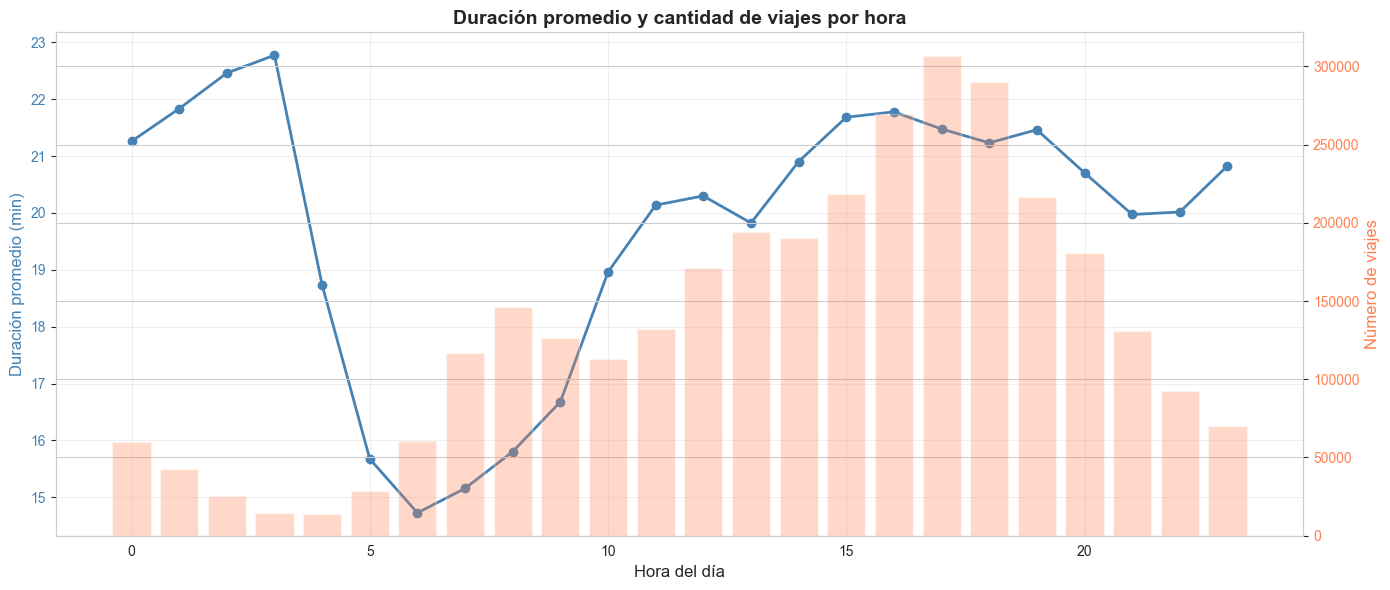

shape: (24, 3)
┌──────┬───────────────────────┬──────────────┐
│ hora ┆ duracion_promedio_min ┆ total_viajes │
│ ---  ┆ ---                   ┆ ---          │
│ i8   ┆ f64                   ┆ u32          │
╞══════╪═══════════════════════╪══════════════╡
│ 0    ┆ 21.259964             ┆ 59760        │
│ 1    ┆ 21.834686             ┆ 42433        │
│ 2    ┆ 22.459518             ┆ 25300        │
│ 3    ┆ 22.773693             ┆ 14645        │
│ 4    ┆ 18.734372             ┆ 14098        │
│ 5    ┆ 15.675041             ┆ 28561        │
│ 6    ┆ 14.727315             ┆ 60228        │
│ 7    ┆ 15.157722             ┆ 117086       │
│ 8    ┆ 15.804081             ┆ 146456       │
│ 9    ┆ 16.679807             ┆ 126332       │
│ …    ┆ …                     ┆ …            │
│ 14   ┆ 20.903215             ┆ 190167       │
│ 15   ┆ 21.683328             ┆ 218250       │
│ 16   ┆ 21.777712             ┆ 269396       │
│ 17   ┆ 21.476325             ┆ 306418       │
│ 18   ┆ 21.233067       

In [69]:
# Duración promedio por franja horaria
duracion_por_hora = (
    df_temporal
    .group_by("hora")
    .agg([
        (pl.col("duracion_recorrido") / 60).mean().alias("duracion_promedio_min"),  # Convertir a minutos
        pl.len().alias("total_viajes")
    ])
    .sort("hora")
)

fig, ax1 = plt.subplots(figsize=(14, 6))

color = 'steelblue'
ax1.set_xlabel('Hora del día', fontsize=12)
ax1.set_ylabel('Duración promedio (min)', color=color, fontsize=12)
ax1.plot(duracion_por_hora["hora"], duracion_por_hora["duracion_promedio_min"], 
         color=color, marker='o', linewidth=2)
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(alpha=0.3)

ax2 = ax1.twinx()
color = 'coral'
ax2.set_ylabel('Número de viajes', color=color, fontsize=12)
ax2.bar(duracion_por_hora["hora"], duracion_por_hora["total_viajes"], 
        alpha=0.3, color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Duración promedio y cantidad de viajes por hora', fontsize=14, fontweight='bold')
fig.tight_layout()
plt.show()

print(duracion_por_hora)

## D. Análisis Geoespacial

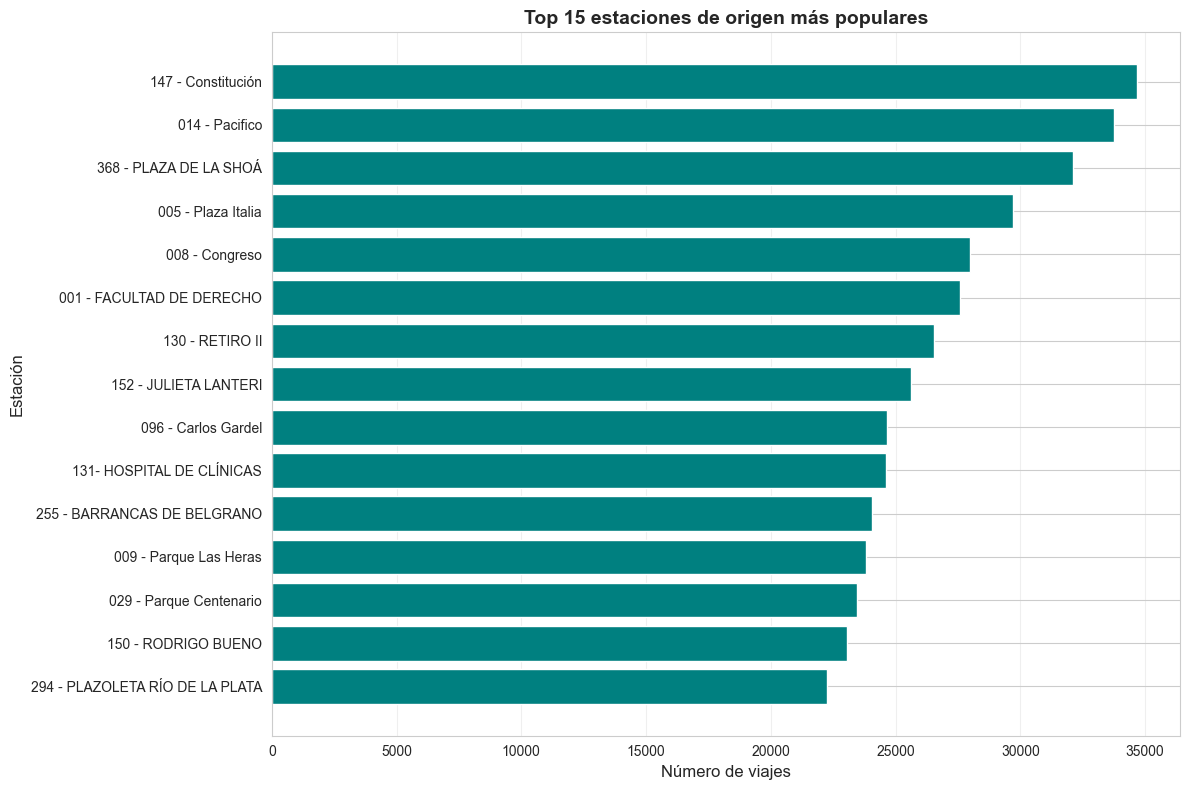

shape: (15, 3)
┌────────────────────┬─────────────────────────────────┬──────────────┐
│ id_estacion_origen ┆ nombre_estacion_origen          ┆ total_viajes │
│ ---                ┆ ---                             ┆ ---          │
│ str                ┆ str                             ┆ u32          │
╞════════════════════╪═════════════════════════════════╪══════════════╡
│ 175                ┆ 147 - Constitución              ┆ 34668        │
│ 14                 ┆ 014 - Pacifico                  ┆ 33765        │
│ 516                ┆ 368 - PLAZA DE LA SHOÁ          ┆ 32124        │
│ 5                  ┆ 005 - Plaza Italia              ┆ 29728        │
│ 8                  ┆ 008 - Congreso                  ┆ 27966        │
│ 202                ┆ 001 - FACULTAD DE DERECHO       ┆ 27575        │
│ 130                ┆ 130 - RETIRO II                 ┆ 26553        │
│ 152                ┆ 152 - JULIETA LANTERI           ┆ 25636        │
│ 96                 ┆ 096 - Carlos Gardel       

In [70]:
# Top 15 estaciones de origen más populares
top_origenes = (
    df_limpio     .group_by(["id_estacion_origen", "nombre_estacion_origen"])
    .agg(pl.len().alias("total_viajes"))
    .sort("total_viajes", descending=True)
    .head(15)
)

plt.figure(figsize=(12, 8))
plt.barh(range(len(top_origenes)), top_origenes["total_viajes"], color='teal')
plt.yticks(range(len(top_origenes)), top_origenes["nombre_estacion_origen"])
plt.xlabel("Número de viajes", fontsize=12)
plt.ylabel("Estación", fontsize=12)
plt.title("Top 15 estaciones de origen más populares", fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

print(top_origenes)

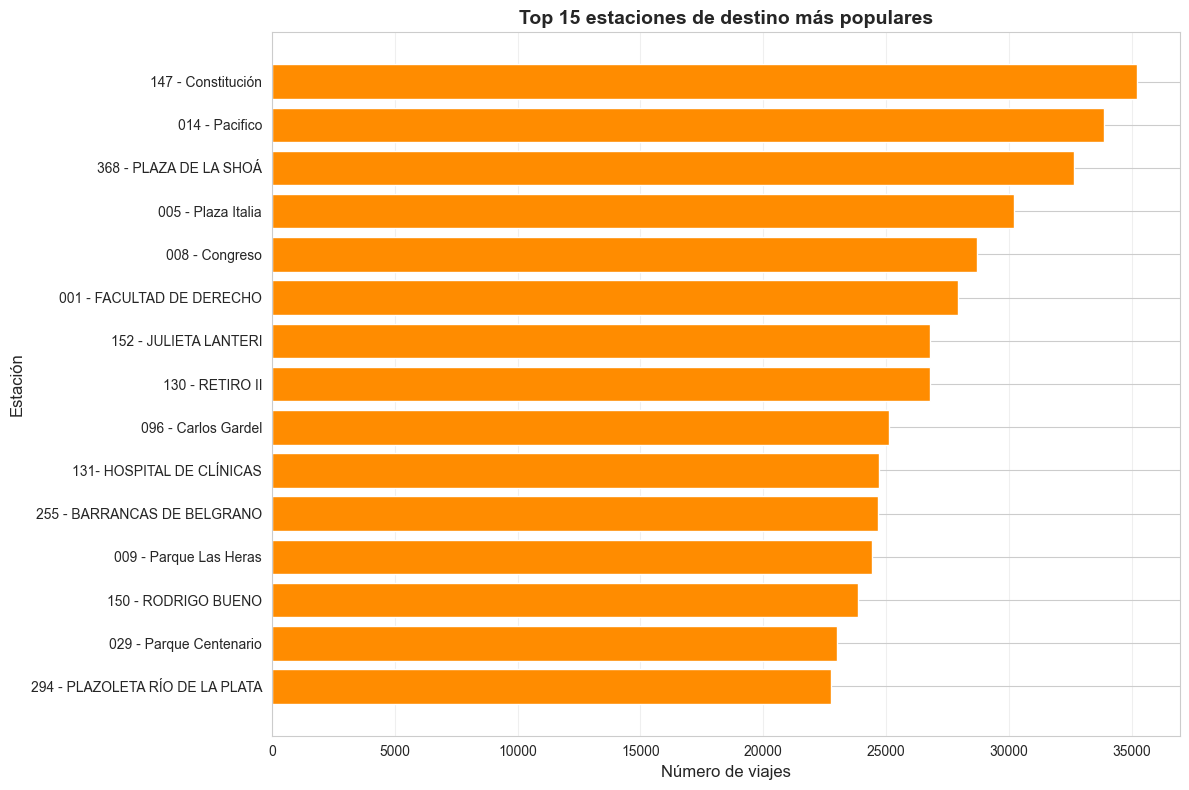

shape: (15, 3)
┌─────────────────────┬─────────────────────────────────┬──────────────┐
│ id_estacion_destino ┆ nombre_estacion_destino         ┆ total_viajes │
│ ---                 ┆ ---                             ┆ ---          │
│ str                 ┆ str                             ┆ u32          │
╞═════════════════════╪═════════════════════════════════╪══════════════╡
│ 175                 ┆ 147 - Constitución              ┆ 35193        │
│ 14                  ┆ 014 - Pacifico                  ┆ 33880        │
│ 516                 ┆ 368 - PLAZA DE LA SHOÁ          ┆ 32659        │
│ 5                   ┆ 005 - Plaza Italia              ┆ 30210        │
│ 8                   ┆ 008 - Congreso                  ┆ 28707        │
│ 202                 ┆ 001 - FACULTAD DE DERECHO       ┆ 27904        │
│ 152                 ┆ 152 - JULIETA LANTERI           ┆ 26789        │
│ 130                 ┆ 130 - RETIRO II                 ┆ 26767        │
│ 96                  ┆ 096 - Carlos

In [71]:
# Top 15 estaciones de destino más populares
top_destinos = (
    df_limpio     .group_by(["id_estacion_destino", "nombre_estacion_destino"])
    .agg(pl.len().alias("total_viajes"))
    .sort("total_viajes", descending=True)
    .head(15)
)

plt.figure(figsize=(12, 8))
plt.barh(range(len(top_destinos)), top_destinos["total_viajes"], color='darkorange')
plt.yticks(range(len(top_destinos)), top_destinos["nombre_estacion_destino"])
plt.xlabel("Número de viajes", fontsize=12)
plt.ylabel("Estación", fontsize=12)
plt.title("Top 15 estaciones de destino más populares", fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

print(top_destinos)

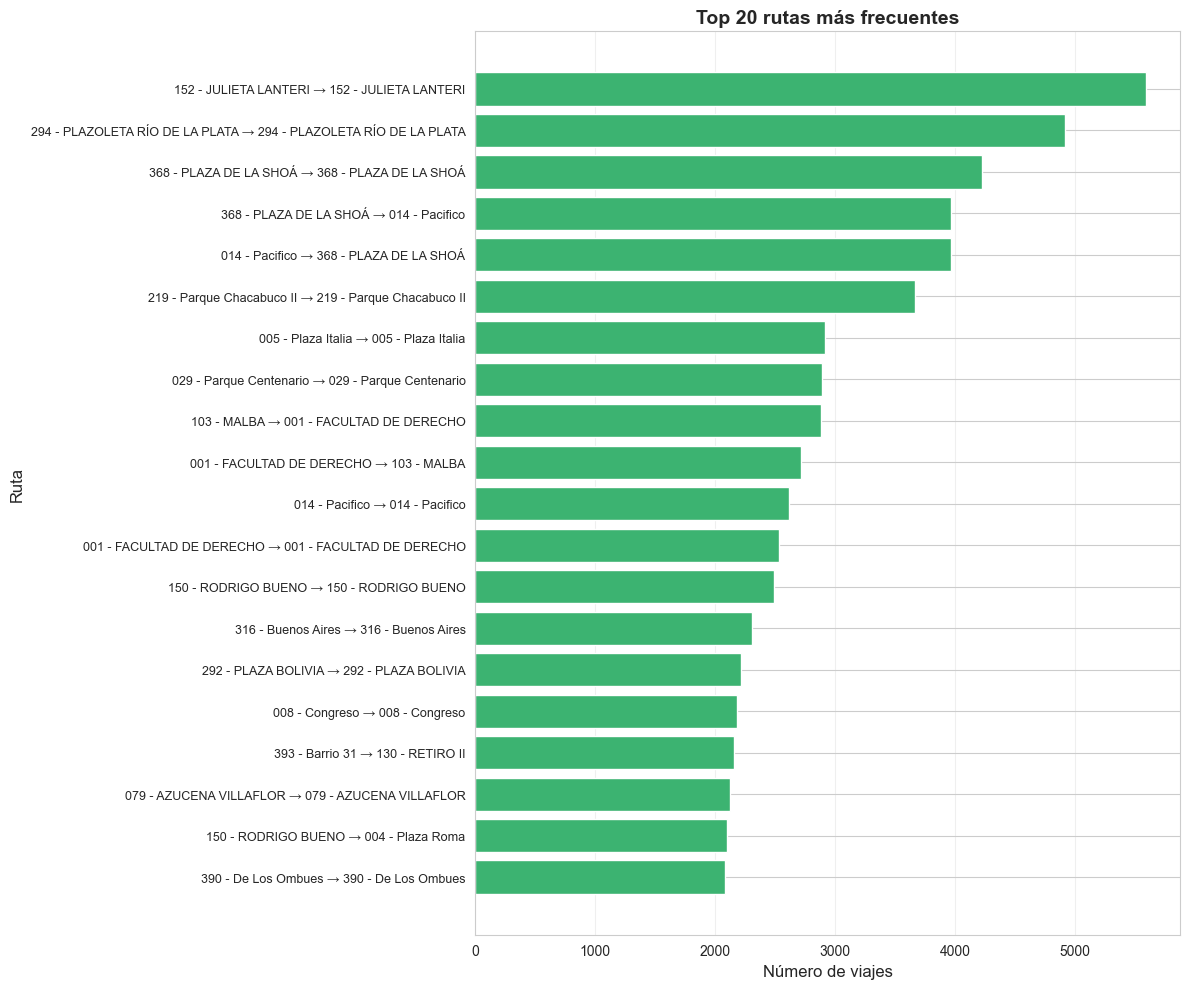

shape: (20, 2)
┌───────────────────────────────────────────────────────────────────┬──────────────┐
│ ruta                                                              ┆ total_viajes │
│ ---                                                               ┆ ---          │
│ str                                                               ┆ u32          │
╞═══════════════════════════════════════════════════════════════════╪══════════════╡
│ 152 - JULIETA LANTERI → 152 - JULIETA LANTERI                     ┆ 5597         │
│ 294 - PLAZOLETA RÍO DE LA PLATA → 294 - PLAZOLETA RÍO DE LA PLATA ┆ 4914         │
│ 368 - PLAZA DE LA SHOÁ → 368 - PLAZA DE LA SHOÁ                   ┆ 4228         │
│ 368 - PLAZA DE LA SHOÁ → 014 - Pacifico                           ┆ 3970         │
│ 014 - Pacifico → 368 - PLAZA DE LA SHOÁ                           ┆ 3967         │
│ 219 - Parque Chacabuco II → 219 - Parque Chacabuco II             ┆ 3670         │
│ 005 - Plaza Italia → 005 - Plaza Italia         

In [72]:
# Top 20 rutas más frecuentes (pares origen-destino)
top_rutas = (
    df_limpio     .group_by(["nombre_estacion_origen", "nombre_estacion_destino"])
    .agg(pl.len().alias("total_viajes"))
    .sort("total_viajes", descending=True)
    .head(20)
    .with_columns(
        (pl.col("nombre_estacion_origen") + " → " + pl.col("nombre_estacion_destino")).alias("ruta")
    )
)

plt.figure(figsize=(12, 10))
plt.barh(range(len(top_rutas)), top_rutas["total_viajes"], color='mediumseagreen')
plt.yticks(range(len(top_rutas)), top_rutas["ruta"], fontsize=9)
plt.xlabel("Número de viajes", fontsize=12)
plt.ylabel("Ruta", fontsize=12)
plt.title("Top 20 rutas más frecuentes", fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

print(top_rutas.select(["ruta", "total_viajes"]))

Top 10 estaciones con mayor actividad total:
shape: (10, 7)
┌─────────────┬──────────────┬─────────────┬─────────────┬─────────────┬─────────────┬─────────────┐
│ id_estacion ┆ nombre_estac ┆ viajes_orig ┆ id_estacion ┆ nombre_esta ┆ viajes_dest ┆ actividad_t │
│ ---         ┆ ion          ┆ en          ┆ _right      ┆ cion_right  ┆ ino         ┆ otal        │
│ str         ┆ ---          ┆ ---         ┆ ---         ┆ ---         ┆ ---         ┆ ---         │
│             ┆ str          ┆ u32         ┆ str         ┆ str         ┆ u32         ┆ u32         │
╞═════════════╪══════════════╪═════════════╪═════════════╪═════════════╪═════════════╪═════════════╡
│ 175         ┆ 147 -        ┆ 34668       ┆ 175         ┆ 147 - Const ┆ 35193       ┆ 69861       │
│             ┆ Constitución ┆             ┆             ┆ itución     ┆             ┆             │
│ 14          ┆ 014 -        ┆ 33765       ┆ 14          ┆ 014 -       ┆ 33880       ┆ 67645       │
│             ┆ Pacifico     ┆ 

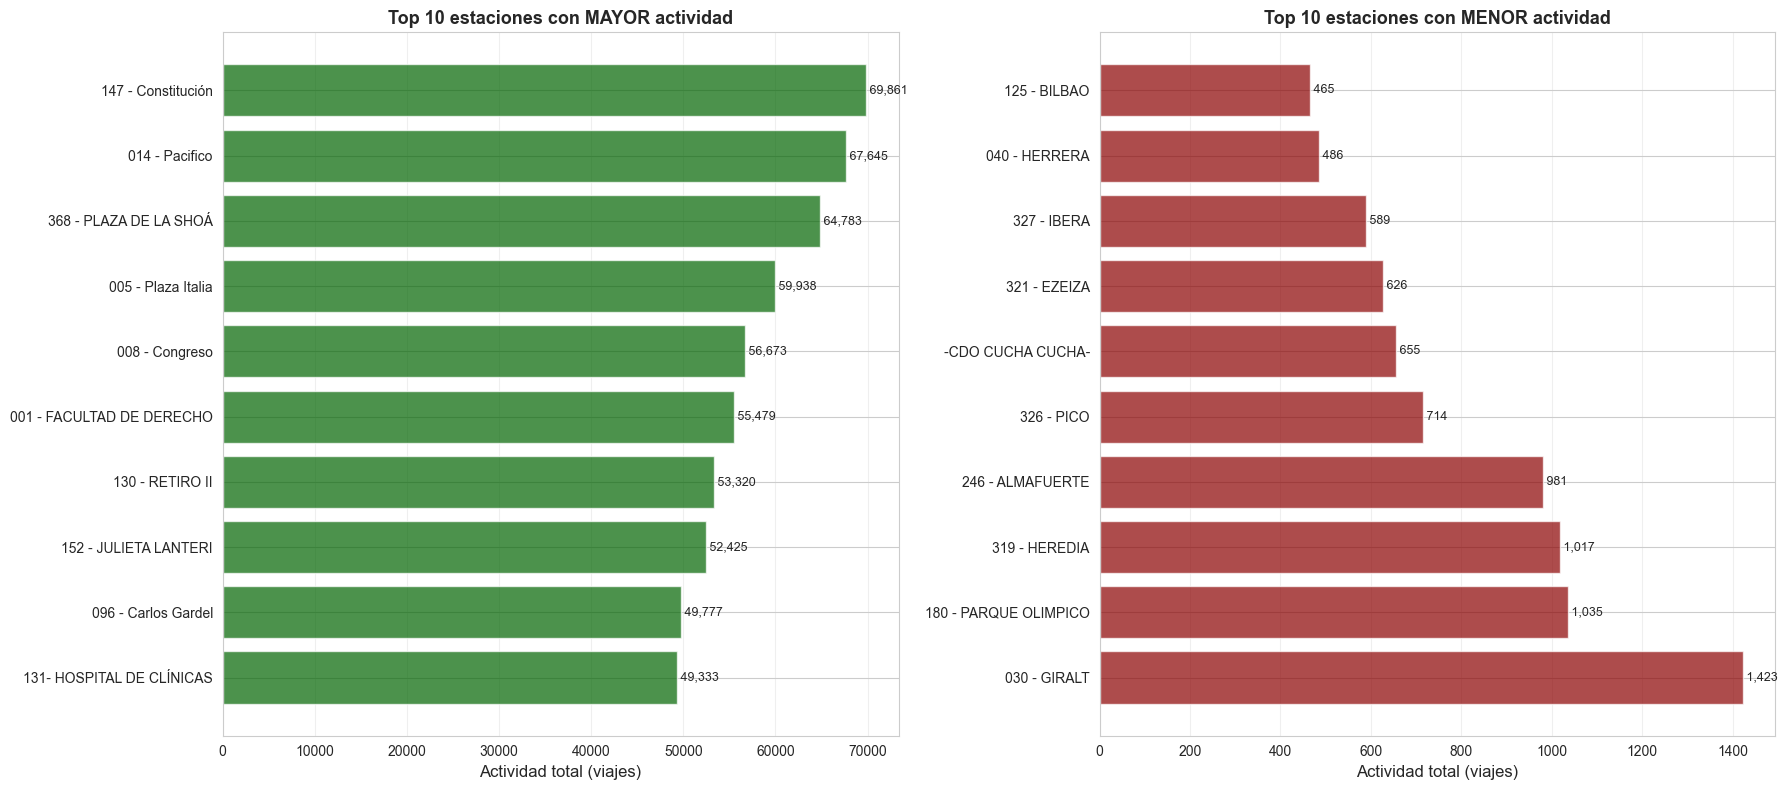


Estadísticas de actividad total:
  • Estación más activa: 147 - Constitución con 69,861 viajes
  • Promedio de actividad (top 10): 57,923 viajes
  • Promedio de actividad (bottom 10): 799 viajes
  • Total de estaciones analizadas: 395


In [73]:
# Actividad total por estación (suma de orígenes y destinos)
actividad_origen = (
    df_limpio     .group_by(["id_estacion_origen", "nombre_estacion_origen"])
    .agg(pl.len().alias("viajes_origen"))
    .rename({"id_estacion_origen": "id_estacion", "nombre_estacion_origen": "nombre_estacion"})
)

actividad_destino = (
    df_limpio     .group_by(["id_estacion_destino", "nombre_estacion_destino"])
    .agg(pl.len().alias("viajes_destino"))
    .rename({"id_estacion_destino": "id_estacion", "nombre_estacion_destino": "nombre_estacion"})
)

actividad_total = (
    actividad_origen
    .join(actividad_destino, on=["id_estacion", "nombre_estacion"], how="full")
    .with_columns([
        pl.col("viajes_origen").fill_null(0),
        pl.col("viajes_destino").fill_null(0),
    ])
    .with_columns(
        (pl.col("viajes_origen") + pl.col("viajes_destino")).alias("actividad_total")
    )
    .sort("actividad_total", descending=True)
)

print("Top 10 estaciones con mayor actividad total:")
print(actividad_total.head(10))

print("\nTop 10 estaciones con menor actividad total:")
print(actividad_total.tail(10))

# Visualización de barras
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))

# Top 10 estaciones con MAYOR actividad
top_10_mayor = actividad_total.head(10)
nombres_mayor = top_10_mayor["nombre_estacion"].to_list()
valores_mayor = top_10_mayor["actividad_total"].to_list()

ax1.barh(range(len(nombres_mayor)), valores_mayor, color='darkgreen', alpha=0.7)
ax1.set_yticks(range(len(nombres_mayor)))
ax1.set_yticklabels(nombres_mayor, fontsize=10)
ax1.set_xlabel("Actividad total (viajes)", fontsize=12)
ax1.set_title("Top 10 estaciones con MAYOR actividad", fontsize=13, fontweight='bold')
ax1.invert_yaxis()
ax1.grid(axis='x', alpha=0.3)
# Agregar valores
for idx, val in enumerate(valores_mayor):
    ax1.text(val, idx, f' {val:,}', va='center', fontsize=9)

# Top 10 estaciones con MENOR actividad (excluyendo nulls)
bottom_10 = actividad_total.filter(pl.col("nombre_estacion").is_not_null()).tail(10).reverse()
nombres_menor = bottom_10["nombre_estacion"].to_list()
valores_menor = bottom_10["actividad_total"].to_list()

ax2.barh(range(len(nombres_menor)), valores_menor, color='darkred', alpha=0.7)
ax2.set_yticks(range(len(nombres_menor)))
ax2.set_yticklabels(nombres_menor, fontsize=10)
ax2.set_xlabel("Actividad total (viajes)", fontsize=12)
ax2.set_title("Top 10 estaciones con MENOR actividad", fontsize=13, fontweight='bold')
ax2.invert_yaxis()
ax2.grid(axis='x', alpha=0.3)
# Agregar valores
for idx, val in enumerate(valores_menor):
    ax2.text(val, idx, f' {val:,}', va='center', fontsize=9)

plt.tight_layout()
plt.show()

# Estadísticas adicionales
print(f"\nEstadísticas de actividad total:")
print(f"  • Estación más activa: {top_10_mayor['nombre_estacion'][0]} con {top_10_mayor['actividad_total'][0]:,} viajes")
print(f"  • Promedio de actividad (top 10): {top_10_mayor['actividad_total'].mean():,.0f} viajes")
print(f"  • Promedio de actividad (bottom 10): {bottom_10['actividad_total'].mean():,.0f} viajes")
print(f"  • Total de estaciones analizadas: {actividad_total.filter(pl.col('nombre_estacion').is_not_null()).height}")

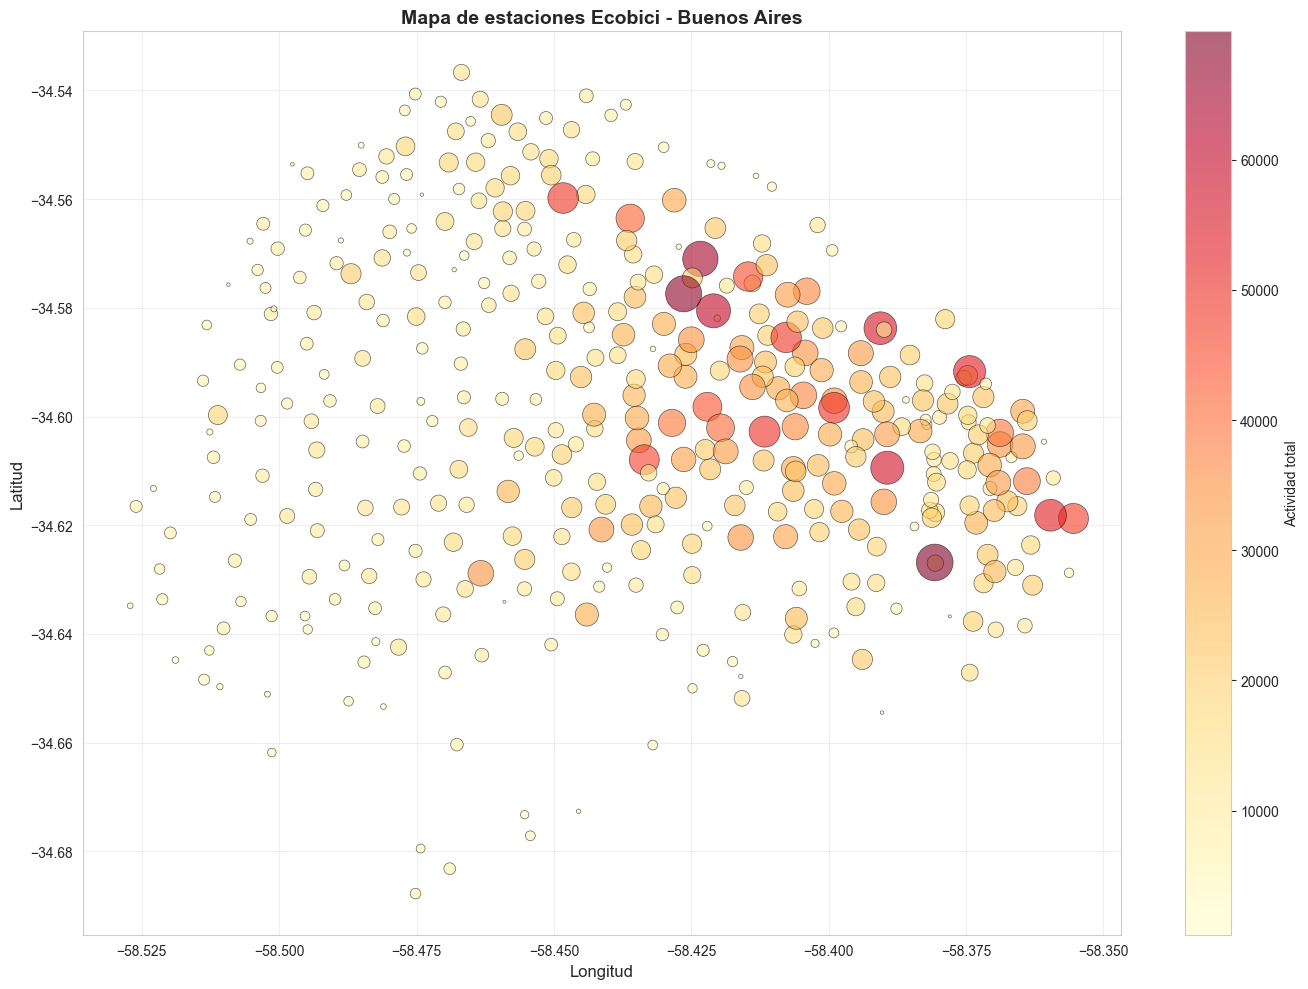

Total de estaciones únicas: 395


In [74]:
# Visualización geográfica de estaciones (scatter plot)

estaciones_coords = (
    df_limpio     .select([
        pl.col("id_estacion_origen").alias("id_estacion"),
        pl.col("nombre_estacion_origen").alias("nombre_estacion"),
        pl.col("lat_estacion_origen").alias("latitud"),
        pl.col("long_estacion_origen").alias("longitud")
    ])
    .unique()
)

# Unir con actividad total
estaciones_mapa = estaciones_coords.join(
    actividad_total.select(["id_estacion", "actividad_total"]),
    on="id_estacion",
    how="left"
)

plt.figure(figsize=(14, 10))
scatter = plt.scatter(
    estaciones_mapa["longitud"], 
    estaciones_mapa["latitud"],
    s=estaciones_mapa["actividad_total"] / 100,  # Tamaño según actividad
    c=estaciones_mapa["actividad_total"],
    cmap='YlOrRd',
    alpha=0.6,
    edgecolors='black',
    linewidth=0.5
)
plt.colorbar(scatter, label='Actividad total')
plt.xlabel("Longitud", fontsize=12)
plt.ylabel("Latitud", fontsize=12)
plt.title("Mapa de estaciones Ecobici - Buenos Aires", fontsize=14, fontweight='bold')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Total de estaciones únicas: {estaciones_coords.height}")

## E. Análisis de Usuarios

shape: (3, 3)
┌────────┬──────────────┬────────────┐
│ genero ┆ total_viajes ┆ porcentaje │
│ ---    ┆ ---          ┆ ---        │
│ str    ┆ u32          ┆ f64        │
╞════════╪══════════════╪════════════╡
│ MALE   ┆ 1952734      ┆ 61.027343  │
│ FEMALE ┆ 1014267      ┆ 31.698132  │
│ OTHER  ┆ 232768       ┆ 7.274525   │
└────────┴──────────────┴────────────┘


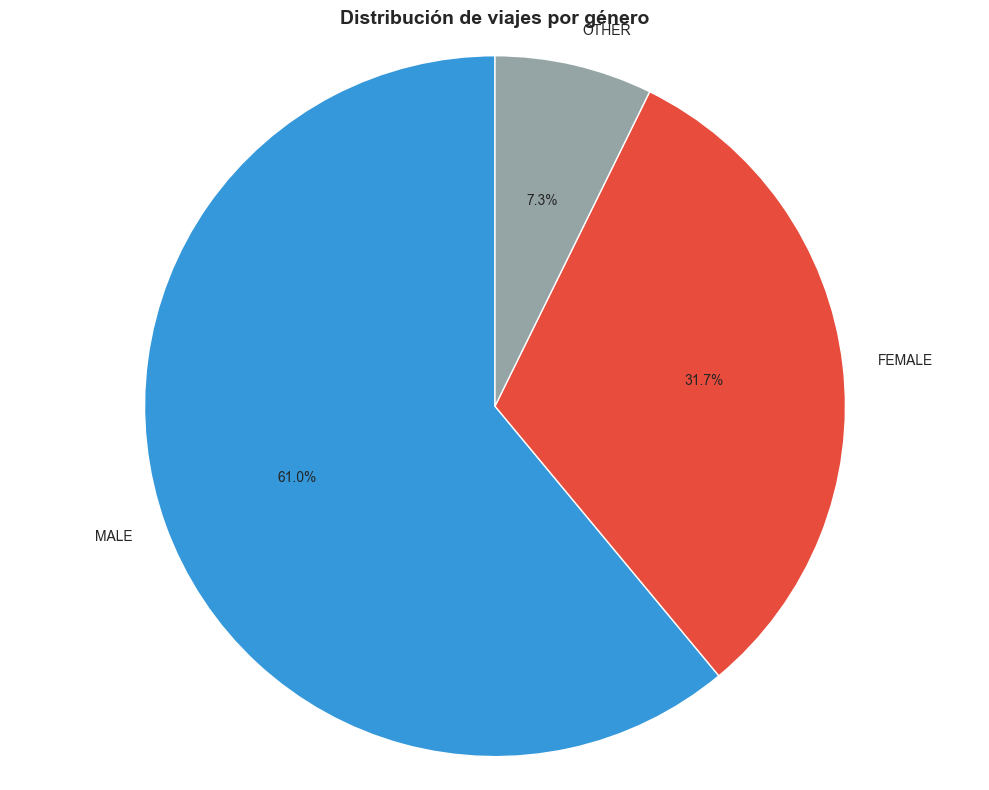

In [75]:
# Distribución por género
dist_genero = (
    df_limpio     .filter(pl.col("genero").is_not_null())  # Filtrar valores nulos
    .group_by("genero")
    .agg(pl.len().alias("total_viajes"))
    .with_columns(
        (pl.col("total_viajes") / pl.col("total_viajes").sum() * 100).alias("porcentaje")
    )
    .sort("total_viajes", descending=True)
)

print(dist_genero)

# Gráfico de torta
plt.figure(figsize=(10, 8))
plt.pie(dist_genero["total_viajes"].to_list(), 
        labels=dist_genero["genero"].to_list(), 
        autopct='%1.1f%%',
        startangle=90,
        colors=['#3498db', '#e74c3c', '#95a5a6'])
plt.title("Distribución de viajes por género", fontsize=14, fontweight='bold')
plt.axis('equal')
plt.tight_layout()
plt.show()

shape: (3, 5)
┌────────┬───────────────────┬──────────────────┬──────────────┬──────────────┐
│ genero ┆ duracion_promedio ┆ duracion_mediana ┆ duracion_std ┆ total_viajes │
│ ---    ┆ ---               ┆ ---              ┆ ---          ┆ ---          │
│ str    ┆ f64               ┆ f64              ┆ f64          ┆ u32          │
╞════════╪═══════════════════╪══════════════════╪══════════════╪══════════════╡
│ FEMALE ┆ 21.79496          ┆ 17.55            ┆ 16.304148    ┆ 1014267      │
│ OTHER  ┆ 21.659378         ┆ 16.683333        ┆ 17.108812    ┆ 232768       │
│ MALE   ┆ 19.107869         ┆ 15.183333        ┆ 14.633155    ┆ 1952734      │
└────────┴───────────────────┴──────────────────┴──────────────┴──────────────┘


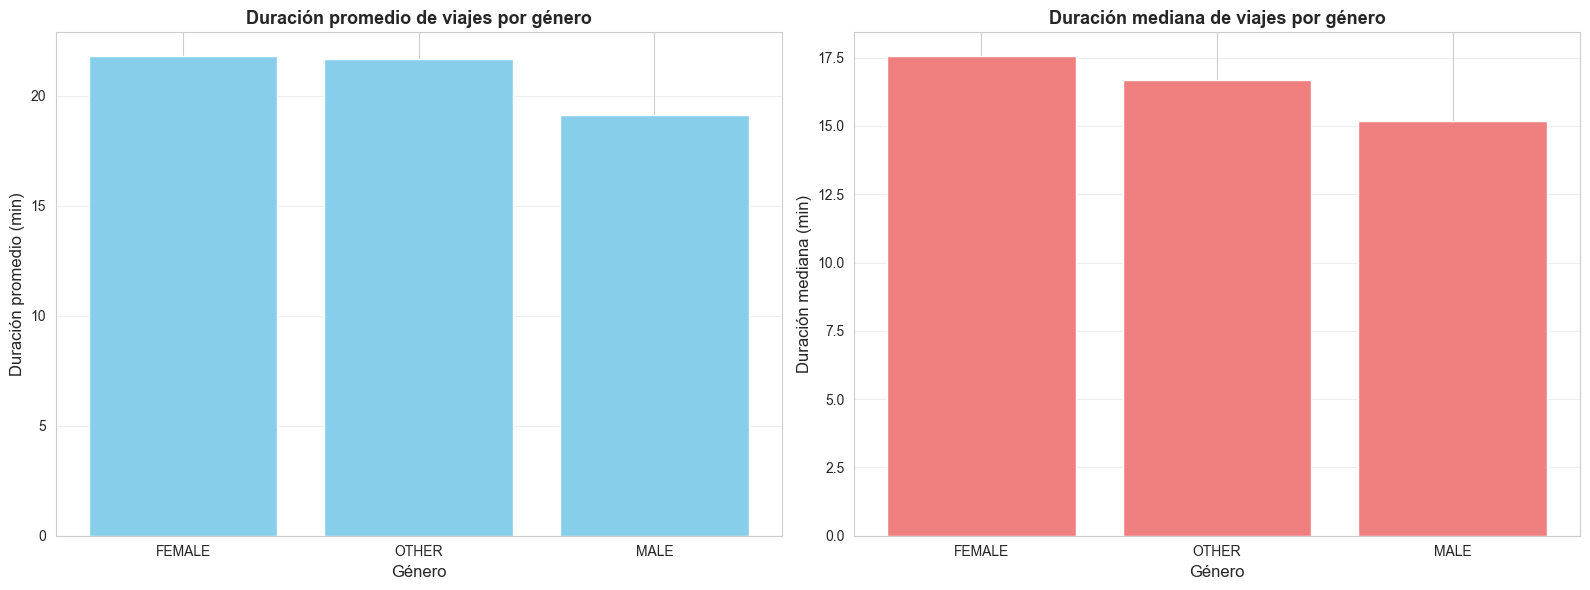

In [76]:
# Duración promedio de viajes por género
duracion_genero = (
    df_limpio     .filter(pl.col("genero").is_not_null())  # Filtrar valores nulos
    .group_by("genero")
    .agg([
        (pl.col("duracion_recorrido") / 60).mean().alias("duracion_promedio"),  # Convertir a minutos
        (pl.col("duracion_recorrido") / 60).median().alias("duracion_mediana"),  # Convertir a minutos
        (pl.col("duracion_recorrido") / 60).std().alias("duracion_std"),  # Convertir a minutos
        pl.len().alias("total_viajes")
    ])
    .sort("duracion_promedio", descending=True)
)

print(duracion_genero)

# Visualización
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Duración promedio
ax1.bar(duracion_genero["genero"].to_list(), duracion_genero["duracion_promedio"].to_list(), color='skyblue')
ax1.set_xlabel("Género", fontsize=12)
ax1.set_ylabel("Duración promedio (min)", fontsize=12)
ax1.set_title("Duración promedio de viajes por género", fontsize=13, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)

# Duración mediana
ax2.bar(duracion_genero["genero"].to_list(), duracion_genero["duracion_mediana"].to_list(), color='lightcoral')
ax2.set_xlabel("Género", fontsize=12)
ax2.set_ylabel("Duración mediana (min)", fontsize=12)
ax2.set_title("Duración mediana de viajes por género", fontsize=13, fontweight='bold')
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

shape: (6, 3)
┌────────┬──────────────────┬──────────────┐
│ genero ┆ modelo_bicicleta ┆ total_viajes │
│ ---    ┆ ---              ┆ ---          │
│ str    ┆ str              ┆ u32          │
╞════════╪══════════════════╪══════════════╡
│ FEMALE ┆ FIT              ┆ 738870       │
│ FEMALE ┆ ICONIC           ┆ 275397       │
│ MALE   ┆ FIT              ┆ 1390619      │
│ MALE   ┆ ICONIC           ┆ 562115       │
│ OTHER  ┆ FIT              ┆ 170073       │
│ OTHER  ┆ ICONIC           ┆ 62695        │
└────────┴──────────────────┴──────────────┘

Distribución de tipos de bicicleta por género:
shape: (3, 3)
┌────────┬─────────┬────────┐
│ genero ┆ FIT     ┆ ICONIC │
│ ---    ┆ ---     ┆ ---    │
│ str    ┆ u32     ┆ u32    │
╞════════╪═════════╪════════╡
│ FEMALE ┆ 738870  ┆ 275397 │
│ MALE   ┆ 1390619 ┆ 562115 │
│ OTHER  ┆ 170073  ┆ 62695  │
└────────┴─────────┴────────┘


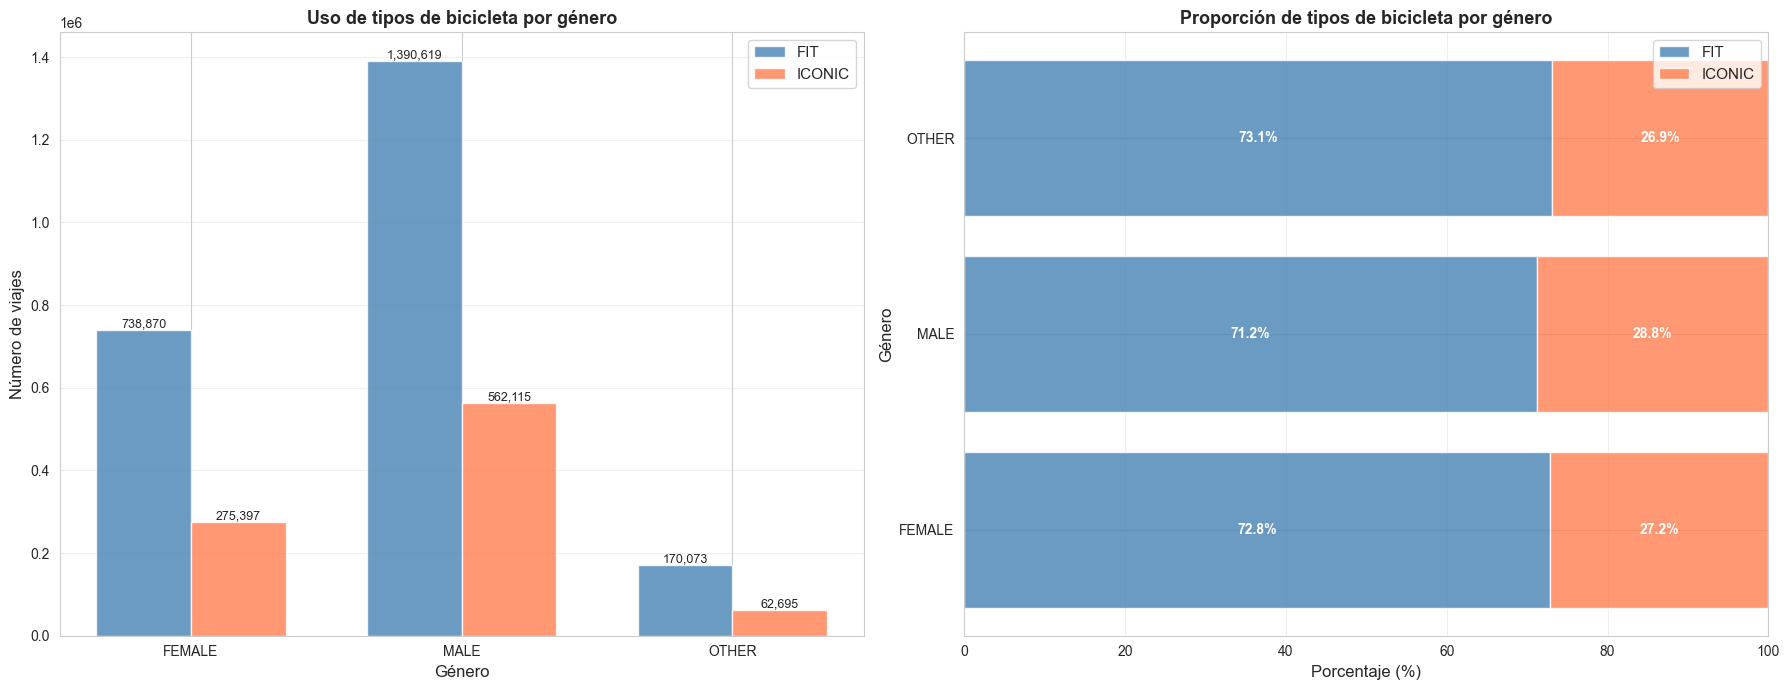


Análisis de preferencias por género:

FEMALE:
  • FIT: 738,870 viajes (72.8%)
  • ICONIC: 275,397 viajes (27.2%)
  • Total: 1,014,267 viajes

MALE:
  • FIT: 1,390,619 viajes (71.2%)
  • ICONIC: 562,115 viajes (28.8%)
  • Total: 1,952,734 viajes

OTHER:
  • FIT: 170,073 viajes (73.1%)
  • ICONIC: 62,695 viajes (26.9%)
  • Total: 232,768 viajes


In [77]:
# Análisis de tipo de bicicleta por género
tipo_bici_genero = (
    df_limpio     .filter(pl.col("genero").is_not_null())  # Filtrar valores nulos en género
    .group_by(["genero", "modelo_bicicleta"])
    .agg(pl.len().alias("total_viajes"))
    .sort(["genero", "total_viajes"], descending=[False, True])
)

print(tipo_bici_genero)

# Pivot para visualización
pivot_bici = tipo_bici_genero.pivot(
    index="genero",
    on="modelo_bicicleta",
    values="total_viajes"
)

print("\nDistribución de tipos de bicicleta por género:")
print(pivot_bici)

# Visualizaciones
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))

# Gráfico 1: Barras agrupadas por género
generos = pivot_bici["genero"].to_list()
fit_counts = pivot_bici["FIT"].to_list()
iconic_counts = pivot_bici["ICONIC"].to_list()

x = range(len(generos))
width = 0.35

bars1 = ax1.bar([i - width/2 for i in x], fit_counts, width, label='FIT', color='steelblue', alpha=0.8)
bars2 = ax1.bar([i + width/2 for i in x], iconic_counts, width, label='ICONIC', color='coral', alpha=0.8)

ax1.set_xlabel("Género", fontsize=12)
ax1.set_ylabel("Número de viajes", fontsize=12)
ax1.set_title("Uso de tipos de bicicleta por género", fontsize=13, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(generos)
ax1.legend(fontsize=11)
ax1.grid(axis='y', alpha=0.3)

# Agregar valores encima de las barras
for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height):,}', ha='center', va='bottom', fontsize=9)
for bar in bars2:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height):,}', ha='center', va='bottom', fontsize=9)

# Gráfico 2: Barras apiladas (proporciones por género)
fit_pct = [(fit_counts[i] / (fit_counts[i] + iconic_counts[i]) * 100) for i in range(len(generos))]
iconic_pct = [(iconic_counts[i] / (fit_counts[i] + iconic_counts[i]) * 100) for i in range(len(generos))]

ax2.barh(generos, fit_pct, color='steelblue', alpha=0.8, label='FIT')
ax2.barh(generos, iconic_pct, left=fit_pct, color='coral', alpha=0.8, label='ICONIC')

ax2.set_xlabel("Porcentaje (%)", fontsize=12)
ax2.set_ylabel("Género", fontsize=12)
ax2.set_title("Proporción de tipos de bicicleta por género", fontsize=13, fontweight='bold')
ax2.legend(fontsize=11)
ax2.set_xlim(0, 100)
ax2.grid(axis='x', alpha=0.3)

# Agregar porcentajes en las barras
for idx, genero in enumerate(generos):
    # FIT
    ax2.text(fit_pct[idx]/2, idx, f'{fit_pct[idx]:.1f}%', 
             ha='center', va='center', fontsize=10, fontweight='bold', color='white')
    # ICONIC
    ax2.text(fit_pct[idx] + iconic_pct[idx]/2, idx, f'{iconic_pct[idx]:.1f}%', 
             ha='center', va='center', fontsize=10, fontweight='bold', color='white')

plt.tight_layout()
plt.show()

# Análisis adicional
print("\nAnálisis de preferencias por género:")
for idx, genero in enumerate(generos):
    total = fit_counts[idx] + iconic_counts[idx]
    print(f"\n{genero}:")
    print(f"  • FIT: {fit_counts[idx]:,} viajes ({fit_pct[idx]:.1f}%)")
    print(f"  • ICONIC: {iconic_counts[idx]:,} viajes ({iconic_pct[idx]:.1f}%)")
    print(f"  • Total: {total:,} viajes")

Total de usuarios únicos en el año: 254,137

Distribución de usuarios por categoría (todo el año):
shape: (5, 3)
┌──────────────────────┬──────────────┬──────────────┐
│ categoria_usuario    ┆ num_usuarios ┆ total_viajes │
│ ---                  ┆ ---          ┆ ---          │
│ str                  ┆ u32          ┆ u32          │
╞══════════════════════╪══════════════╪══════════════╡
│ Frecuente (21-50)    ┆ 21031        ┆ 672443       │
│ Muy frecuente (>50)  ┆ 14618        ┆ 1616700      │
│ Ocasional (1 viaje)  ┆ 73510        ┆ 73510        │
│ Poco frecuente (2-5) ┆ 91302        ┆ 273216       │
│ Moderado (6-20)      ┆ 53676        ┆ 574976       │
└──────────────────────┴──────────────┴──────────────┘


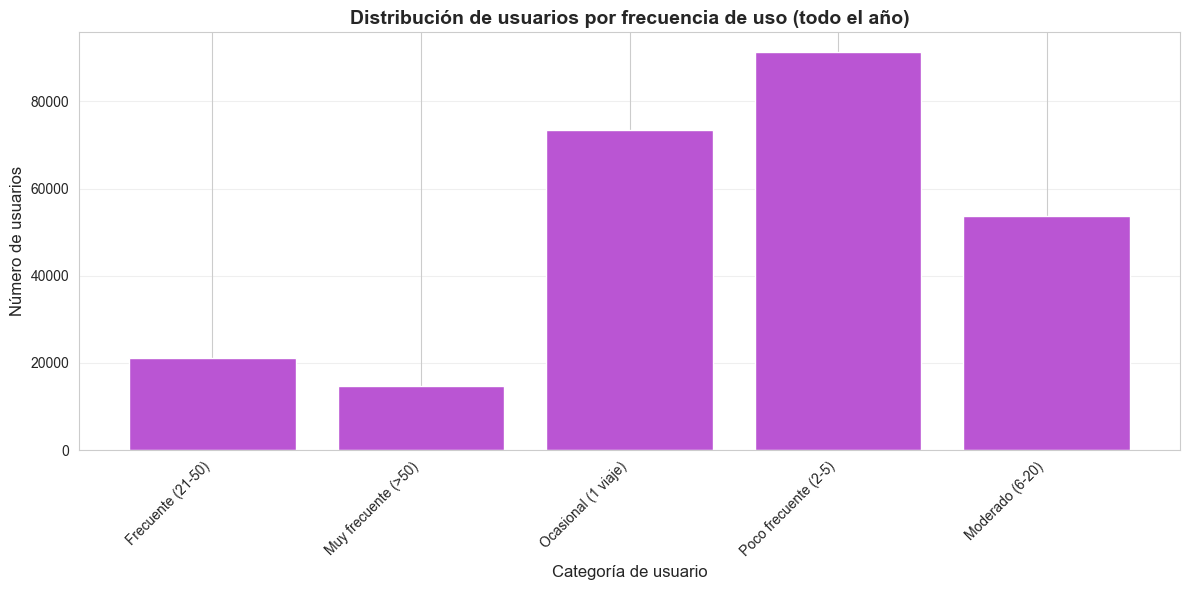

In [78]:
# Usuarios únicos y frecuencia de uso - General
usuarios_frecuencia = (
    df_limpio     .group_by("id_usuario")
    .agg(pl.len().alias("viajes_realizados"))
    .with_columns(
        pl.when(pl.col("viajes_realizados") == 1).then(pl.lit("Ocasional (1 viaje)"))
        .when(pl.col("viajes_realizados") <= 5).then(pl.lit("Poco frecuente (2-5)"))
        .when(pl.col("viajes_realizados") <= 20).then(pl.lit("Moderado (6-20)"))
        .when(pl.col("viajes_realizados") <= 50).then(pl.lit("Frecuente (21-50)"))
        .otherwise(pl.lit("Muy frecuente (>50)"))
        .alias("categoria_usuario")
    )
)

resumen_usuarios = (
    usuarios_frecuencia
    .group_by("categoria_usuario")
    .agg([
        pl.len().alias("num_usuarios"),
        pl.col("viajes_realizados").sum().alias("total_viajes")
    ])
)

print(f"Total de usuarios únicos en el año: {usuarios_frecuencia.height:,}")
print("\nDistribución de usuarios por categoría (todo el año):")
print(resumen_usuarios)

# Visualización general
plt.figure(figsize=(12, 6))
plt.bar(resumen_usuarios["categoria_usuario"].to_list(), resumen_usuarios["num_usuarios"].to_list(), color='mediumorchid')
plt.xlabel("Categoría de usuario", fontsize=12)
plt.ylabel("Número de usuarios", fontsize=12)
plt.title("Distribución de usuarios por frecuencia de uso (todo el año)", fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

Usuarios únicos por mes:
shape: (12, 2)
┌─────┬─────────────────┐
│ mes ┆ usuarios_unicos │
│ --- ┆ ---             │
│ i8  ┆ u32             │
╞═════╪═════════════════╡
│ 1   ┆ 53970           │
│ 2   ┆ 52546           │
│ 3   ┆ 59870           │
│ 4   ┆ 52518           │
│ 5   ┆ 46835           │
│ 6   ┆ 47009           │
│ 7   ┆ 46995           │
│ 8   ┆ 48023           │
│ 9   ┆ 64135           │
│ 10  ┆ 68073           │
│ 11  ┆ 66796           │
│ 12  ┆ 64500           │
└─────┴─────────────────┘


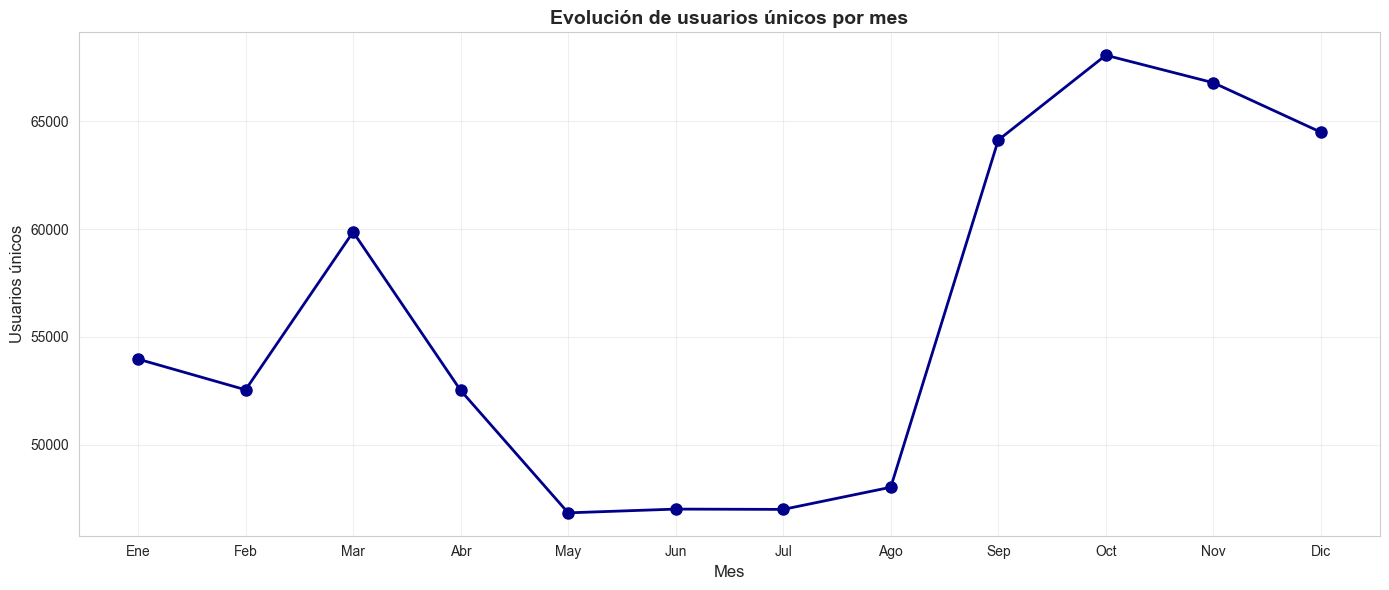


Distribución de categorías de usuarios por mes:
shape: (60, 3)
┌─────┬──────────────────────┬──────────────┐
│ mes ┆ categoria            ┆ num_usuarios │
│ --- ┆ ---                  ┆ ---          │
│ i8  ┆ str                  ┆ u32          │
╞═════╪══════════════════════╪══════════════╡
│ 1   ┆ Frecuente (21-50)    ┆ 2119         │
│ 1   ┆ Moderado (6-20)      ┆ 11308        │
│ 1   ┆ Muy frecuente (>50)  ┆ 109          │
│ 1   ┆ Ocasional (1)        ┆ 18180        │
│ 1   ┆ Poco frecuente (2-5) ┆ 22254        │
│ 2   ┆ Frecuente (21-50)    ┆ 1770         │
│ 2   ┆ Moderado (6-20)      ┆ 11284        │
│ 2   ┆ Muy frecuente (>50)  ┆ 67           │
│ 2   ┆ Ocasional (1)        ┆ 17561        │
│ 2   ┆ Poco frecuente (2-5) ┆ 21864        │
│ …   ┆ …                    ┆ …            │
│ 11  ┆ Frecuente (21-50)    ┆ 2420         │
│ 11  ┆ Moderado (6-20)      ┆ 13623        │
│ 11  ┆ Muy frecuente (>50)  ┆ 99           │
│ 11  ┆ Ocasional (1)        ┆ 23775        │
│ 11  ┆ Poco fre

In [79]:
# Análisis de usuarios únicos y frecuencia por mes

df_usuarios_mes = df_limpio.with_columns([
    pl.col("fecha_origen_recorrido").dt.month().alias("mes"),
])

# Usuarios únicos por mes
usuarios_por_mes = (
    df_usuarios_mes
    .group_by("mes")
    .agg(pl.col("id_usuario").n_unique().alias("usuarios_unicos"))
    .sort("mes")
)

meses_nombres = ["Ene", "Feb", "Mar", "Abr", "May", "Jun", "Jul", "Ago", "Sep", "Oct", "Nov", "Dic"]

print("Usuarios únicos por mes:")
print(usuarios_por_mes)

# Visualización de usuarios únicos por mes
plt.figure(figsize=(14, 6))
plt.plot(usuarios_por_mes["mes"].to_list(), usuarios_por_mes["usuarios_unicos"].to_list(), 
         marker='o', linewidth=2, markersize=8, color='darkblue')
plt.xlabel("Mes", fontsize=12)
plt.ylabel("Usuarios únicos", fontsize=12)
plt.title("Evolución de usuarios únicos por mes", fontsize=14, fontweight='bold')
plt.xticks(usuarios_por_mes["mes"].to_list(), 
           [meses_nombres[m-1] for m in usuarios_por_mes["mes"].to_list()])
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Frecuencia de uso por mes (categorizar usuarios según viajes en cada mes)
frecuencia_mensual = (
    df_usuarios_mes
    .group_by(["mes", "id_usuario"])
    .agg(pl.len().alias("viajes_mes"))
    .with_columns(
        pl.when(pl.col("viajes_mes") == 1).then(pl.lit("Ocasional (1)"))
        .when(pl.col("viajes_mes") <= 5).then(pl.lit("Poco frecuente (2-5)"))
        .when(pl.col("viajes_mes") <= 20).then(pl.lit("Moderado (6-20)"))
        .when(pl.col("viajes_mes") <= 50).then(pl.lit("Frecuente (21-50)"))
        .otherwise(pl.lit("Muy frecuente (>50)"))
        .alias("categoria")
    )
    .group_by(["mes", "categoria"])
    .agg(pl.len().alias("num_usuarios"))
    .sort(["mes", "categoria"])
)

print("\nDistribución de categorías de usuarios por mes:")
print(frecuencia_mensual)

# Crear pivot para visualización
pivot_frecuencia = frecuencia_mensual.pivot(
    index="mes",
    on="categoria",
    values="num_usuarios"
).sort("mes")

print("\nPivot - Categorías por mes:")
print(pivot_frecuencia)

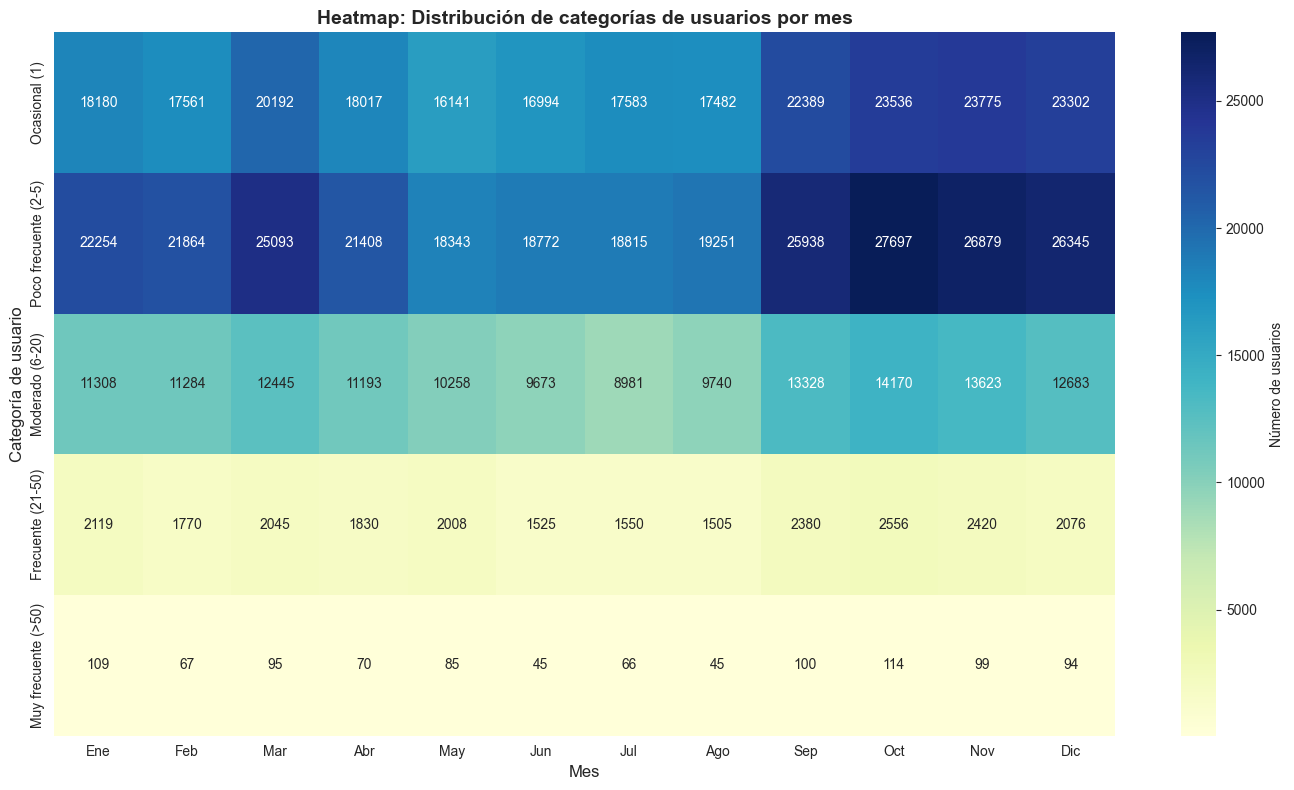


Porcentaje de cada categoría por mes:

Ene:
  Frecuente (21-50): 3.9% (2,119 usuarios)
  Moderado (6-20): 21.0% (11,308 usuarios)
  Muy frecuente (>50): 0.2% (109 usuarios)
  Ocasional (1): 33.7% (18,180 usuarios)
  Poco frecuente (2-5): 41.2% (22,254 usuarios)

Feb:
  Frecuente (21-50): 3.4% (1,770 usuarios)
  Moderado (6-20): 21.5% (11,284 usuarios)
  Muy frecuente (>50): 0.1% (67 usuarios)
  Ocasional (1): 33.4% (17,561 usuarios)
  Poco frecuente (2-5): 41.6% (21,864 usuarios)

Mar:
  Frecuente (21-50): 3.4% (2,045 usuarios)
  Moderado (6-20): 20.8% (12,445 usuarios)
  Muy frecuente (>50): 0.2% (95 usuarios)
  Ocasional (1): 33.7% (20,192 usuarios)
  Poco frecuente (2-5): 41.9% (25,093 usuarios)

Abr:
  Frecuente (21-50): 3.5% (1,830 usuarios)
  Moderado (6-20): 21.3% (11,193 usuarios)
  Muy frecuente (>50): 0.1% (70 usuarios)
  Ocasional (1): 34.3% (18,017 usuarios)
  Poco frecuente (2-5): 40.8% (21,408 usuarios)

May:
  Frecuente (21-50): 4.3% (2,008 usuarios)
  Moderado (6-20): 

In [80]:
# Heatmap: Distribución de categorías de usuarios por mes
import numpy as np

# Preparar matriz para heatmap
categorias_orden = ["Ocasional (1)", "Poco frecuente (2-5)", "Moderado (6-20)", "Frecuente (21-50)", "Muy frecuente (>50)"]
meses_nombres = ["Ene", "Feb", "Mar", "Abr", "May", "Jun", "Jul", "Ago", "Sep", "Oct", "Nov", "Dic"]

# Crear matriz con todas las combinaciones
matriz_data = []
for categoria in categorias_orden:
    fila = []
    for mes in range(1, 13):
        valor = frecuencia_mensual.filter(
            (pl.col("mes") == mes) & (pl.col("categoria") == categoria)
        )["num_usuarios"]
        fila.append(valor[0] if len(valor) > 0 else 0)
    matriz_data.append(fila)

matriz_heatmap = np.array(matriz_data)

plt.figure(figsize=(14, 8))
sns.heatmap(matriz_heatmap, 
            xticklabels=meses_nombres[:len(usuarios_por_mes)],
            yticklabels=categorias_orden,
            cmap="YlGnBu", 
            annot=True, 
            fmt=".0f",
            cbar_kws={'label': 'Número de usuarios'})
plt.xlabel("Mes", fontsize=12)
plt.ylabel("Categoría de usuario", fontsize=12)
plt.title("Heatmap: Distribución de categorías de usuarios por mes", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Análisis adicional: Porcentaje de cada categoría por mes
porcentajes_mes = (
    frecuencia_mensual
    .with_columns(
        (pl.col("num_usuarios") / pl.col("num_usuarios").sum().over("mes") * 100).alias("porcentaje")
    )
    .sort(["mes", "categoria"])
)

print("\nPorcentaje de cada categoría por mes:")
for mes in porcentajes_mes["mes"].unique().sort():
    print(f"\n{meses_nombres[mes-1]}:")
    datos_mes = porcentajes_mes.filter(pl.col("mes") == mes)
    for row in datos_mes.iter_rows(named=True):
        print(f"  {row['categoria']}: {row['porcentaje']:.1f}% ({row['num_usuarios']:,} usuarios)")

Top 10 usuarios con más viajes:
shape: (10, 2)
┌────────────┬──────────────┐
│ id_usuario ┆ total_viajes │
│ ---        ┆ ---          │
│ str        ┆ u32          │
╞════════════╪══════════════╡
│ 668737.0   ┆ 1235         │
│ 12434.0    ┆ 966          │
│ 373935.0   ┆ 880          │
│ 89898.0    ┆ 873          │
│ 996973.0   ┆ 845          │
│ 28486.0    ┆ 818          │
│ 746687.0   ┆ 804          │
│ 1024648.0  ┆ 796          │
│ 330716.0   ┆ 787          │
│ 444458.0   ┆ 780          │
└────────────┴──────────────┘


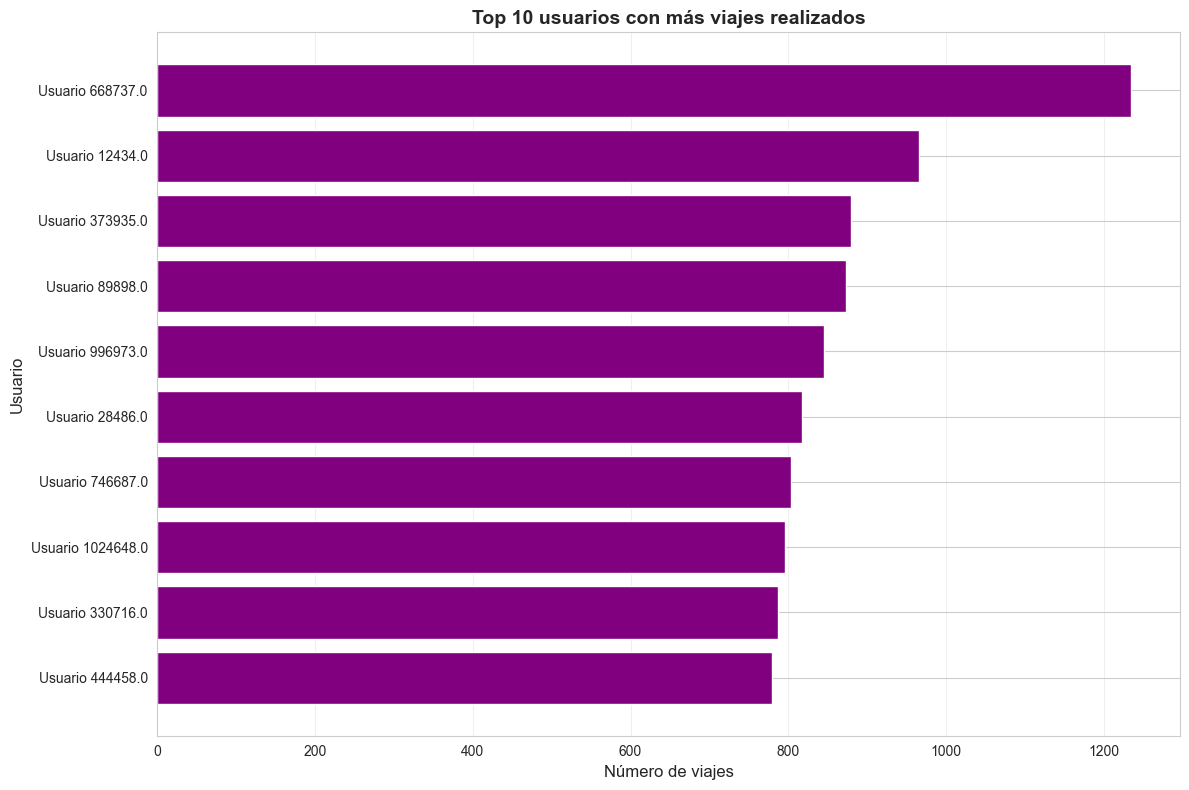


Promedio de viajes entre top 10 usuarios: 878
Usuario más activo: 668737.0 con 1,235 viajes
Total de viajes de top 10: 8,784 (0.25% del total)


In [81]:
# Top 10 usuarios con más viajes
top_10_usuarios = (
    df_limpio     .group_by("id_usuario")
    .agg(pl.len().alias("total_viajes"))
    .sort("total_viajes", descending=True)
    .head(10)
)

print("Top 10 usuarios con más viajes:")
print(top_10_usuarios)

# Visualización
plt.figure(figsize=(12, 8))
plt.barh(range(len(top_10_usuarios)), top_10_usuarios["total_viajes"].to_list(), color='purple')
plt.yticks(range(len(top_10_usuarios)), 
           [f"Usuario {uid}" for uid in top_10_usuarios["id_usuario"].to_list()])
plt.xlabel("Número de viajes", fontsize=12)
plt.ylabel("Usuario", fontsize=12)
plt.title("Top 10 usuarios con más viajes realizados", fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

# Estadísticas adicionales
print(f"\nPromedio de viajes entre top 10 usuarios: {top_10_usuarios['total_viajes'].mean():,.0f}")
print(f"Usuario más activo: {top_10_usuarios['id_usuario'][0]} con {top_10_usuarios['total_viajes'][0]:,} viajes")
print(f"Total de viajes de top 10: {top_10_usuarios['total_viajes'].sum():,} ({top_10_usuarios['total_viajes'].sum()/df.height*100:.2f}% del total)")